# Economical Effects on Cars Sales

## Initialization

### Imports

In [1]:
# import the needed Libraries

from pandas_datareader import data as pdr
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
import warnings
from scipy import stats

In [2]:
# This cuts down on warning that are being displayed as it is part of the deprecated process
warnings.simplefilter(action='ignore', category=FutureWarning)

### Opening Vehicle sales dataset

The dataset is available in the following website and is a csv file type.

https://www.kaggle.com/datasets/suraj520/car-sales-data

The code below extracts and identifies the unique car manufactures of the sales data set. The start and end dates of the set are also captured, so they can be fed into the yahoo API to grab stock prices within the same window of time.

In [3]:
# Open the sales data as a pandas df from the csv
raw_car_sales_df = pd.read_csv("car_sales_data.csv")
display(raw_car_sales_df.head())

# check the unique make of all vehicles in the set
print(raw_car_sales_df["Car Make"].unique())

#copy the datset to keep the origanl
car_sales_df = raw_car_sales_df.copy()

# put dates in datetime format and get the date of the first and last cars sold
car_sales_df["Date"] = pd.to_datetime(car_sales_df["Date"], format="%Y-%m-%d")

# Get the start and stop dates of the set, so they can be passed into the yahoo API
sales_start_date = car_sales_df["Date"].min().strftime("%Y-%m-%d")
sales_end_date = car_sales_df["Date"].max().strftime("%Y-%m-%d")
print(sales_start_date)
print(sales_end_date)

Date      Salesperson   Customer Name Car Make  Car Model  Car Year  \
0  2022-08-01  Monica Moore MD     Mary Butler   Nissan     Altima      2018   
1  2023-03-15     Roberto Rose  Richard Pierce   Nissan      F-150      2016   
2  2023-04-29     Ashley Ramos    Sandra Moore     Ford      Civic      2016   
3  2022-09-04   Patrick Harris    Johnny Scott     Ford     Altima      2013   
4  2022-06-16       Eric Lopez   Vanessa Jones    Honda  Silverado      2022   

   Sale Price  Commission Rate  Commission Earned  
0       15983         0.070495            1126.73  
1       38474         0.134439            5172.40  
2       33340         0.114536            3818.63  
3       41937         0.092191            3866.20  
4       20256         0.113490            2298.85

['Nissan' 'Ford' 'Honda' 'Toyota' 'Chevrolet']
2022-05-01
2023-05-01


## Data Gathering

### Yahoo API Data Grab For Price for Stock/ Index/ Crypto

The packages are not pre installed on the servers and will need to be pip installed. Open a terminal on Coursera and Input line below or use the requirments.txt file to pip install off of for the a virtual environment.

https://pypi.org/project/yfinance/

- pip install pandas_datareader

- pip install yfinance

In [5]:
# initialization
# Dates
start_date = sales_start_date
end_date = sales_end_date
# Stocks_Crypto
# Specify the stock/ cryto to grab
# "^DJI" -> Dow Jones Industrial, "^GSPC" -> SP500, "CL=F" -> Crude Oil
# "TSLA" -> Tesla, "F" -> Ford, "BTC" -> Bitcoin, "CL=F" -> Crude Oil, "HMC" -> Honda
# "NSANY" -> Nissan, "TM" -> Toyota
s_c = ["^DJI","^GSPC","CL=F","BTC-USD","TSLA","F","HMC","NSANY","TM", "GM"]
# The data set can be srunk down by calling out a frame or multiple ["Open","High","Low","Close","Adj Close","Volume"]
#col = ["Open","Close"]
col = ['Close', 'Volume']



# Example code for pulling the stock price as a downloaded dataframe
# Example for bitcoin
# data = pdr.get_data_yahoo("BTC-USD", start="2020-01-01", end="2022-04-30")

# Create a function to get the data from Yahoo Finance API
def get_market_data(s_c, start_date, end_date, col=["Open","Close"]):
    """
    get_market_data uses yfinance to get values on passed in stocks or cryptos  

    :param s_c: This is a list of stocks and or crypto
    :param start_date: This is the starting date of the data set to be collected should be formated as "2021-01-01"
    :param end_date: This is the ending date of the data set to be collected should be formated as "2022-04-30"
    :param col: These are the feilds that should be sub selected from the returned from yfinance

    :return: A dataframe is returned with all the desired stocks/ cryptos
    """ 
    # Loop through all of the desired stocks and pull the data from the yahoo finance API
    for index, stock in enumerate(s_c):
        yf.pdr_override()
        data = pdr.get_data_yahoo(stock, start=start_date, end=end_date)[col]
        for item in col:
            temp_text = stock + "_" + item
            #print(temp_text)
            data = data.rename(columns={item: temp_text})
        #print(data)
        print(stock, index)
        if index == 0:
            df_data = data
        else:
            df_data = pd.merge(df_data,data, on=['Date'], how='outer')

    return df_data

df = get_market_data(s_c, start_date, end_date, col)

display(df)

[*********************100%%**********************]  1 of 1 completed
^DJI 0
[*********************100%%**********************]  1 of 1 completed
^GSPC 1
[*********************100%%**********************]  1 of 1 completed
CL=F 2
[*********************100%%**********************]  1 of 1 completed
BTC-USD 3
[*********************100%%**********************]  1 of 1 completed
TSLA 4
[*********************100%%**********************]  1 of 1 completed
F 5
[*********************100%%**********************]  1 of 1 completed
HMC 6
[*********************100%%**********************]  1 of 1 completed
NSANY 7
[*********************100%%**********************]  1 of 1 completed
TM 8
[*********************100%%**********************]  1 of 1 completed
GM 9


^DJI_Close  ^DJI_Volume  ^GSPC_Close  ^GSPC_Volume  CL=F_Close  \
Date                                                                           
2022-05-02  33061.500000  453390000.0  4155.379883  5.163790e+09  105.169998   
2022-05-03  33128.789062  364420000.0  4175.479980  4.582050e+09  102.410004   
2022-05-04  34061.058594  411060000.0  4300.169922  5.136360e+09  107.809998   
2022-05-05  32997.968750  448420000.0  4146.870117  5.077030e+09  108.260002   
2022-05-06  32899.371094  416520000.0  4123.339844  5.116940e+09  109.769997   
...                  ...          ...          ...           ...         ...   
2023-04-16           NaN          NaN          NaN           NaN         NaN   
2023-04-22           NaN          NaN          NaN           NaN         NaN   
2023-04-23           NaN          NaN          NaN           NaN         NaN   
2023-04-29           NaN          NaN          NaN           NaN         NaN   
2023-04-30           NaN          NaN          NaN           NaN         NaN   

            CL=F_Volume  BTC-USD_Close  BTC-USD_Volume  TSLA_Close  \
Date                                                                 
2022-05-02     261878.0   38529.328125     32922642426  300.980011   
2022-05-03     239266.0   37750.453125     27326943244  303.083344   
2022-05-04     272909.0   39698.371094     36754404490  317.540009   
2022-05-05     286916.0   36575.140625     43106256317  291.093323   
2022-05-06     294278.0   36040.921875     37795577489  288.549988   
...                 ...            ...             ...         ...   
2023-04-16          NaN   30315.355469     12854816417         NaN   
2023-04-22          NaN   27817.500000     13125734602         NaN   
2023-04-23          NaN   27591.384766     12785446832         NaN   
2023-04-29          NaN   29248.488281     10662634333         NaN   
2023-04-30          NaN   29268.806641     14652199272         NaN   

            TSLA_Volume  F_Close    F_Volume  HMC_Close  HMC_Volume  \
Date                                                                  
2022-05-02   75781500.0    14.27  64734000.0  26.260000   1008700.0   
2022-05-03   63709500.0    14.56  55734200.0  26.580000   1000500.0   
2022-05-04   81643800.0    14.98  59774900.0  27.120001    774300.0   
2022-05-05   92519100.0    14.53  57889200.0  26.350000   1116000.0   
2022-05-06   72903000.0    14.21  66622200.0  26.680000   1484900.0   
...                 ...      ...         ...        ...         ...   
2023-04-16          NaN      NaN         NaN        NaN         NaN   
2023-04-22          NaN      NaN         NaN        NaN         NaN   
2023-04-23          NaN      NaN         NaN        NaN         NaN   
2023-04-29          NaN      NaN         NaN        NaN         NaN   
2023-04-30          NaN      NaN         NaN        NaN         NaN   

            NSANY_Close  NSANY_Volume    TM_Close  TM_Volume   GM_Close  \
Date                                                                      
2022-05-02         7.90      122400.0  170.690002   178500.0  38.450001   
2022-05-03         7.99      142200.0  172.059998   163600.0  39.939999   
2022-05-04         8.13       74400.0  174.850006   204700.0  41.169998   
2022-05-05         7.88       74300.0  169.929993   331700.0  39.950001   
2022-05-06         7.95      114200.0  173.300003   293400.0  39.580002   
...                 ...           ...         ...        ...        ...   
2023-04-16          NaN           NaN         NaN        NaN        NaN   
2023-04-22          NaN           NaN         NaN        NaN        NaN   
2023-04-23          NaN           NaN         NaN        NaN        NaN   
2023-04-29          NaN           NaN         NaN        NaN        NaN   
2023-04-30          NaN           NaN         NaN        NaN        NaN   

             GM_Volume  
Date                    
2022-05-02  16119900.0  
2022-05-03  19132700.0  
2022-05-04  15813700.0  
2022-05-05  15317100.0  
2022-05-06  

## Data Manipulation

### Create a count of sales per day

In [6]:
sales_count = raw_car_sales_df.groupby(['Date']).size() # car units sold by date
sales_count.name = 'Car Sales Count'
sales_count
sales_count.index = pd.to_datetime(sales_count.index)

### Create a sum of all of the sales per day

In [7]:
sales_total = raw_car_sales_df.groupby(['Date']).sum()
sales_total = sales_total['Sale Price']
sales_total.head()
sales_total.index = pd.to_datetime(sales_total.index)
print(sales_total.index)

DatetimeIndex(['2022-05-01', '2022-05-02', '2022-05-03', '2022-05-04',
               '2022-05-05', '2022-05-06', '2022-05-07', '2022-05-08',
               '2022-05-09', '2022-05-10',
               ...
               '2023-04-22', '2023-04-23', '2023-04-24', '2023-04-25',
               '2023-04-26', '2023-04-27', '2023-04-28', '2023-04-29',
               '2023-04-30', '2023-05-01'],
              dtype='datetime64[ns]', name='Date', length=366, freq=None)


Check to see if there were any sales dates that did not have sales values for them. To make sure we did not have to backward, forwards, or drop the data.

In [8]:
full_date_range = pd.date_range(start=sales_start_date, end=sales_end_date, freq='D')
len(full_date_range.difference(car_sales_df['Date']))

0

There were  no blank dates.

## Merge the data sets

As there are no differences between our Date series and full range of date series, we know that every day of the week cars were sold, therefore, we can make a left merge to mantain all dates and then fill the empty values with the last value because the market value does not change when the market is closed.

In [9]:
print(df.index)
print(sales_count.index)

merged_df = pd.merge(sales_count ,df, on='Date', how="left")
merged_df = pd.merge(sales_total, merged_df, on='Date', how="left")
merged_df.ffill(inplace=True)
merged_df.bfill(inplace=True)
display(merged_df)

DatetimeIndex(['2022-05-02', '2022-05-03', '2022-05-04', '2022-05-05',
               '2022-05-06', '2022-05-09', '2022-05-10', '2022-05-11',
               '2022-05-12', '2022-05-13',
               ...
               '2023-04-02', '2023-04-07', '2023-04-08', '2023-04-09',
               '2023-04-15', '2023-04-16', '2023-04-22', '2023-04-23',
               '2023-04-29', '2023-04-30'],
              dtype='datetime64[ns]', name='Date', length=365, freq=None)
DatetimeIndex(['2022-05-01', '2022-05-02', '2022-05-03', '2022-05-04',
               '2022-05-05', '2022-05-06', '2022-05-07', '2022-05-08',
               '2022-05-09', '2022-05-10',
               ...
               '2023-04-22', '2023-04-23', '2023-04-24', '2023-04-25',
               '2023-04-26', '2023-04-27', '2023-04-28', '2023-04-29',
               '2023-04-30', '2023-05-01'],
              dtype='datetime64[ns]', name='Date', length=366, freq=None)


Sale Price  Car Sales Count    ^DJI_Close  ^DJI_Volume  \
Date                                                                 
2022-05-01   206949043             6887  33061.500000  453390000.0   
2022-05-02   203189741             6811  33061.500000  453390000.0   
2022-05-03   203205280             6810  33128.789062  364420000.0   
2022-05-04   208495677             6953  34061.058594  411060000.0   
2022-05-05   202638034             6815  32997.968750  448420000.0   
...                ...              ...           ...          ...   
2023-04-27   206900660             6901  33826.160156  343240000.0   
2023-04-28   205440999             6890  34098.160156  354310000.0   
2023-04-29   198624340             6589  34098.160156  354310000.0   
2023-04-30   204277723             6808  34098.160156  354310000.0   
2023-05-01   205686470             6839  34098.160156  354310000.0   

            ^GSPC_Close  ^GSPC_Volume  CL=F_Close  CL=F_Volume  BTC-USD_Close  \
Date                                                                            
2022-05-01  4155.379883  5.163790e+09  105.169998     261878.0   38469.093750   
2022-05-02  4155.379883  5.163790e+09  105.169998     261878.0   38529.328125   
2022-05-03  4175.479980  4.582050e+09  102.410004     239266.0   37750.453125   
2022-05-04  4300.169922  5.136360e+09  107.809998     272909.0   39698.371094   
2022-05-05  4146.870117  5.077030e+09  108.260002     286916.0   36575.140625   
...                 ...           ...         ...          ...            ...   
2023-04-27  4135.350098  3.750550e+09   74.760002     345880.0   29473.787109   
2023-04-28  4169.479980  4.087800e+09   76.779999     328399.0   29340.261719   
2023-04-29  4169.479980  4.087800e+09   76.779999     328399.0   29248.488281   
2023-04-30  4169.479980  4.087800e+09   76.779999     328399.0   29268.806641   
2023-05-01  4169.479980  4.087800e+09   76.779999     328399.0   29268.806641   

            BTC-USD_Volume  ...  F_Close    F_Volume  HMC_Close  HMC_Volume  \
Date                        ...                                               
2022-05-01    2.700276e+10  ...    14.27  64734000.0  26.260000   1008700.0   
2022-05-02    3.292264e+10  ...    14.27  64734000.0  26.260000   1008700.0   
2022-05-03    2.732694e+10  ...    14.56  55734200.0  26.580000   1000500.0   
2022-05-04    3.675440e+10  ...    14.98  59774900.0  27.120001    774300.0   
2022-05-05    4.310626e+10  ...    14.53  57889200.0  26.350000   1116000.0   
...                    ...  ...      ...         ...        ...         ...   
2023-04-27    2.715345e+10  ...    11.61  53280300.0  26.490000   1264200.0   
2023-04-28    1.754446e+10  ...    11.88  54996800.0  26.580000    980200.0   
2023-04-29    1.066263e+10  ...    11.88  54996800.0  26.580000    980200.0   
2023-04-30    1.465220e+10  ...    11.88  54996800.0  26.580000    980200.0   
2023-05-01    1.465220e+10  ...    11.88  54996800.0  26.580000    980200.0   

            NSANY_Close  NSANY_Volume    TM_Close  TM_Volume   GM_Close  \
Date                                                                      
2022-05-01         7.90      122400.0  170.690002   178500.0  38.450001   
2022-05-02         7.90      122400.0  170.690002   178500.0  38.450001   
2022-05-03         7.99      142200.0  172.059998   163600.0  39.939999   
2022-05-04         8.13       74400.0  174.850006   204700.0  41.169998   
2022-05-05         7.88       74300.0  169.929993   331700.0  39.950001   
...                 ...           ...         ...        ...        ...   
2023-04-27         7.24       83800.0  137.520004   323600.0  32.720001   
2023-04-28         7.26       49700.0  137.330002   300000.0  33.040001   
2023-04-29         7.26       49700.0  137.330002   300000.0  33.040001   
2023-04-30         7.26       49700.0  137.330002   300000.0  33.040001   
2023-05-01         7.26       49700.0  137.330002   300000.0  33.040001   

             GM_Volume  
Date              

## Correlation Matrix

A critical step in our data exploration process was to visualize and interpret a correlation matrix. At the intersection of car sales data and financial indicator data, understanding their relationships is paramount. So, why exactly did we take this approach?

1. **Understanding Linear Relationships**: 
   - The primary goal of a correlation matrix is to identify and measure linear relationships between variables. By quantifying these relationships, we can quickly grasp how two variables might change relative to each other.

2. **Filtering Relevant Variables**: 
   - In datasets with multiple variables, like ours, not all variables will be equally relevant or informative. Correlation matrices help us filter out variables that might not have significant linear relationships with our target variables, thereby streamlining subsequent analyses.

3. **Avoiding Multicollinearity**: 
   - In predictive modeling, having multiple variables that are highly correlated can lead to multicollinearity, which can adversely impact the model. By identifying these variables early, we can take precautions to handle them appropriately in later stages.

4. **Initial Data Insights**: 
   - Before diving deep into more complex analyses, a correlation matrix provides an initial sense of the data. It's a holistic view that showcases potential areas of interest or variables that might be worth further exploration.

5. **Informative Visualization**: 
   - Heatmaps of correlation matrices provide a visually intuitive representation of relationships. It allows for quick comparisons and contrasts, making it easier to identify patterns or anomalies.

In our specific context, after analyzing the correlation matrix, we observed no significant linear correlations between the car sales data and the financial indicator data, with values hovering close to zero. While a strong correlation might have given us immediate actionable insights, the absence of it was equally informative. It indicated that mere linear relationships might not capture the nuances of our data, prompting us to dig deeper and explore more intricate analyses.


In [10]:
merged_df.corr() #correlation matrix

Sale Price  Car Sales Count  ^DJI_Close  ^DJI_Volume  \
Sale Price         1.000000         0.933156   -0.013350    -0.041873   
Car Sales Count    0.933156         1.000000   -0.040945    -0.020444   
^DJI_Close        -0.013350        -0.040945    1.000000    -0.329013   
^DJI_Volume       -0.041873        -0.020444   -0.329013     1.000000   
^GSPC_Close       -0.025915        -0.058083    0.779203    -0.289937   
^GSPC_Volume      -0.038561        -0.017408   -0.365912     0.880426   
CL=F_Close         0.045461         0.058798   -0.341362     0.140843   
CL=F_Volume       -0.063775        -0.089494   -0.006474    -0.160168   
BTC-USD_Close     -0.027282        -0.031601    0.154133     0.045623   
BTC-USD_Volume    -0.023931        -0.008866   -0.251919     0.267490   
TSLA_Close        -0.028491        -0.022061   -0.412623     0.104002   
TSLA_Volume        0.078385         0.065467    0.441284    -0.014698   
F_Close           -0.050652        -0.060548    0.337473    -0.105453   
F_Volume           0.037350         0.030120   -0.213010     0.540927   
HMC_Close         -0.105073        -0.126577    0.398264    -0.168525   
HMC_Volume         0.093632         0.110962   -0.335288     0.273970   
NSANY_Close       -0.063366        -0.064852    0.075699    -0.050830   
NSANY_Volume       0.073805         0.086287   -0.302532     0.087131   
TM_Close           0.016590         0.018340    0.028859     0.043835   
TM_Volume         -0.047310        -0.051857   -0.365422     0.326918   
GM_Close          -0.027583        -0.023079    0.513146    -0.093339   
GM_Volume          0.035217         0.071290   -0.184077     0.534578   

                 ^GSPC_Close  ^GSPC_Volume  CL=F_Close  CL=F_Volume  \
Sale Price         -0.025915     -0.038561    0.045461    -0.063775   
Car Sales Count    -0.058083     -0.017408    0.058798    -0.089494   
^DJI_Close          0.779203     -0.365912   -0.341362    -0.006474   
^DJI_Volume        -0.289937      0.880426    0.140843    -0.160168   
^GSPC_Close         1.000000     -0.275898   -0.018019     0.020265   
^GSPC_Volume       -0.275898      1.000000    0.177990    -0.086679   
CL=F_Close         -0.018019      0.177990    1.000000    -0.042678   
CL=F_Volume         0.020265     -0.086679   -0.042678     1.000000   
BTC-USD_Close       0.522788      0.099794    0.353336    -0.022930   
BTC-USD_Volume     -0.174428      0.299107    0.245373     0.112382   
TSLA_Close          0.146987      0.145776    0.513291     0.022706   
TSLA_Volume         0.146273     -0.064759   -0.424595     0.076077   
F_Close             0.582612     -0.150417    0.123353     0.011048   
F_Volume           -0.105862      0.559321   -0.130238     0.053180   
HMC_Close           0.772680     -0.089000    0.088131     0.049230   
HMC_Volume         -0.320774      0.287649    0.243187     0.080120   
NSANY_Close         0.527879      0.094247    0.510826     0.077019   
NSANY_Volume       -0.419363      0.078392   -0.102325     0.008570   
TM_Close            0.393416      0.073158    0.800199     0.022166   
TM_Volume          -0.237916      0.281208    0.131074     0.017177   
GM_Close            0.513247     -0.117573   -0.147860     0.011211   
GM_Volume          -0.110036      0.516151    0.140887    -0.069810   

                 BTC-USD_Close  BTC-USD_Volume  ...   F_Close  F_Volume  \
Sale Price           -0.027282       -0.023931  ... -0.050652  0.037350   
Car Sales Count      -0.031601       -0.008866  ... -0.060548  0.030120   
^DJI_Close            0.154133       -0.251919  ...  0.337473 -0.213010   
^DJI_Volume           0.045623        0.267490  ... -0.105453  0.540927   
^GSPC_Close           0.522788       -0.174428  ...  0.582612 -0.105862   
^GSPC_Volume          0.099794        0.299107  ... -0.150417  0.559321   
CL=F_Close            0.353336        0.245373  ...  0.123353 -0.130238   
CL=F_Volume          -0.022930        0.112382  ...  0.011048  0.053180   
BTC-USD_Close         1.0000

## Correlation Heatmap

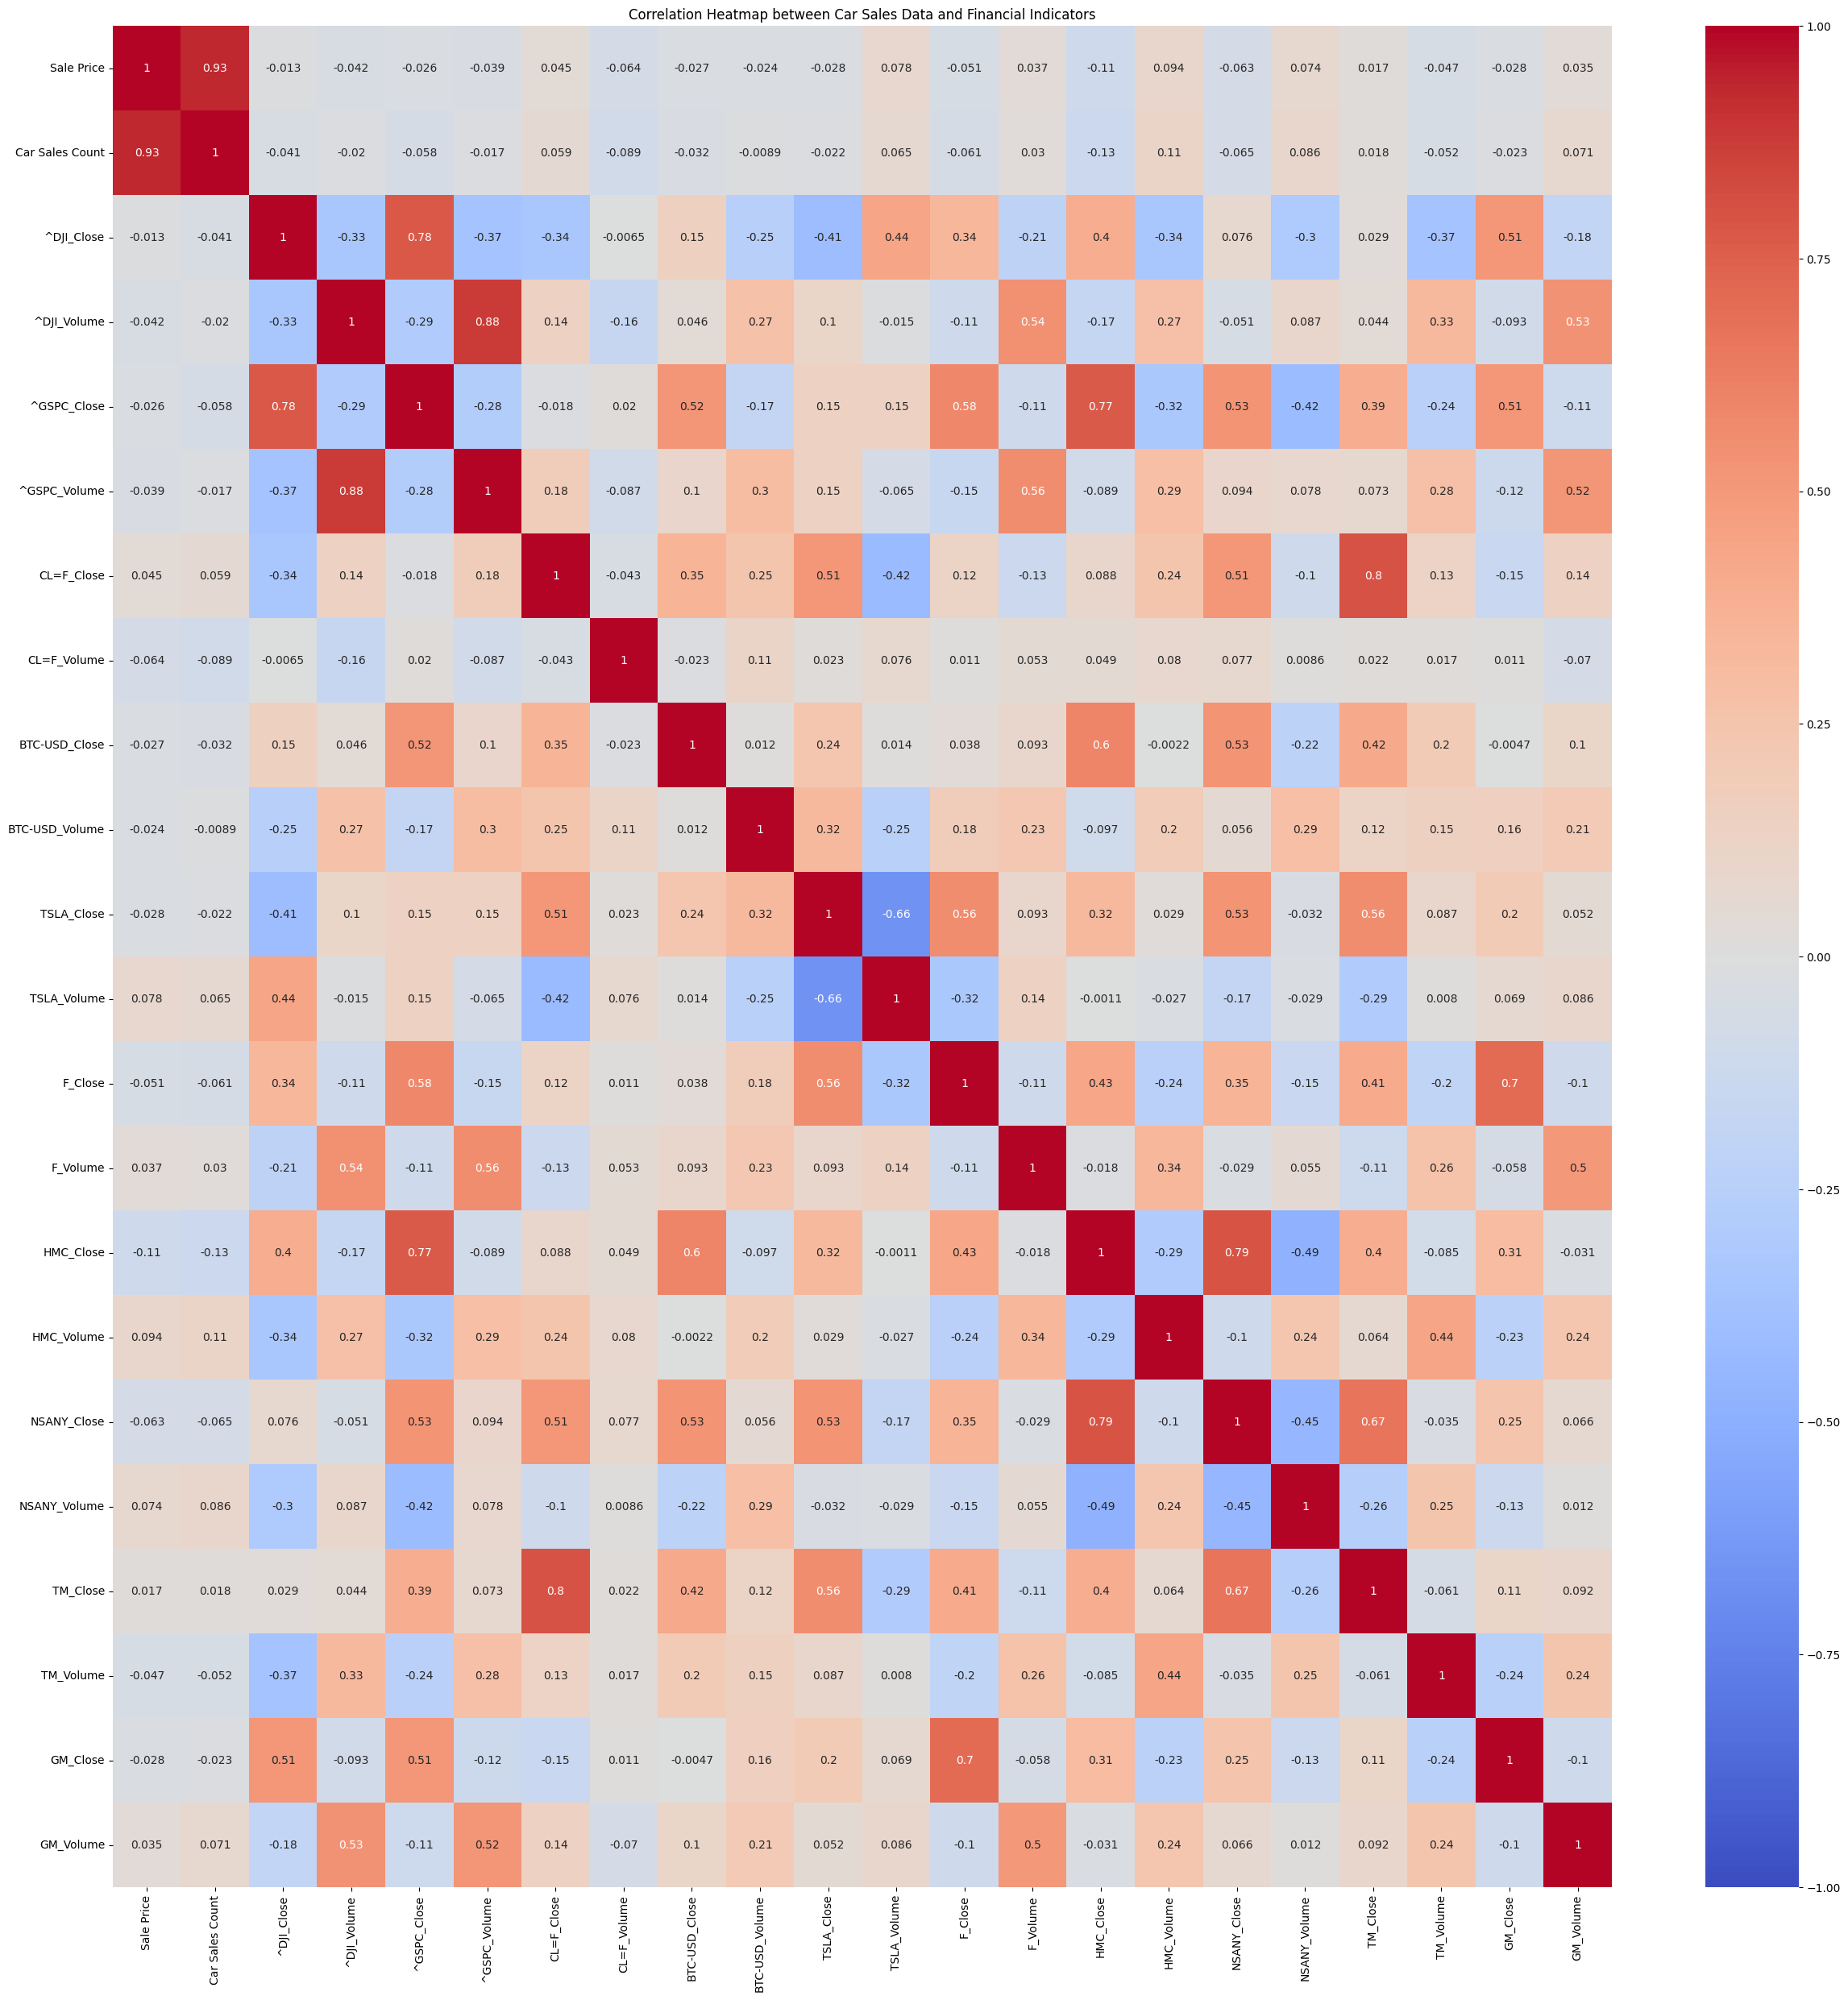

In [11]:
corr_matrix = merged_df.corr()

plt.figure(figsize=(30, 30))  # Optional: Adjust the figure size
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap between Car Sales Data and Financial Indicators")
plt.show()

Since our data has so many columns, we will cut them down and put them in 'test_columns', which are columns that showed some potential interest in the later steps so that the correlation matrix is more readable.

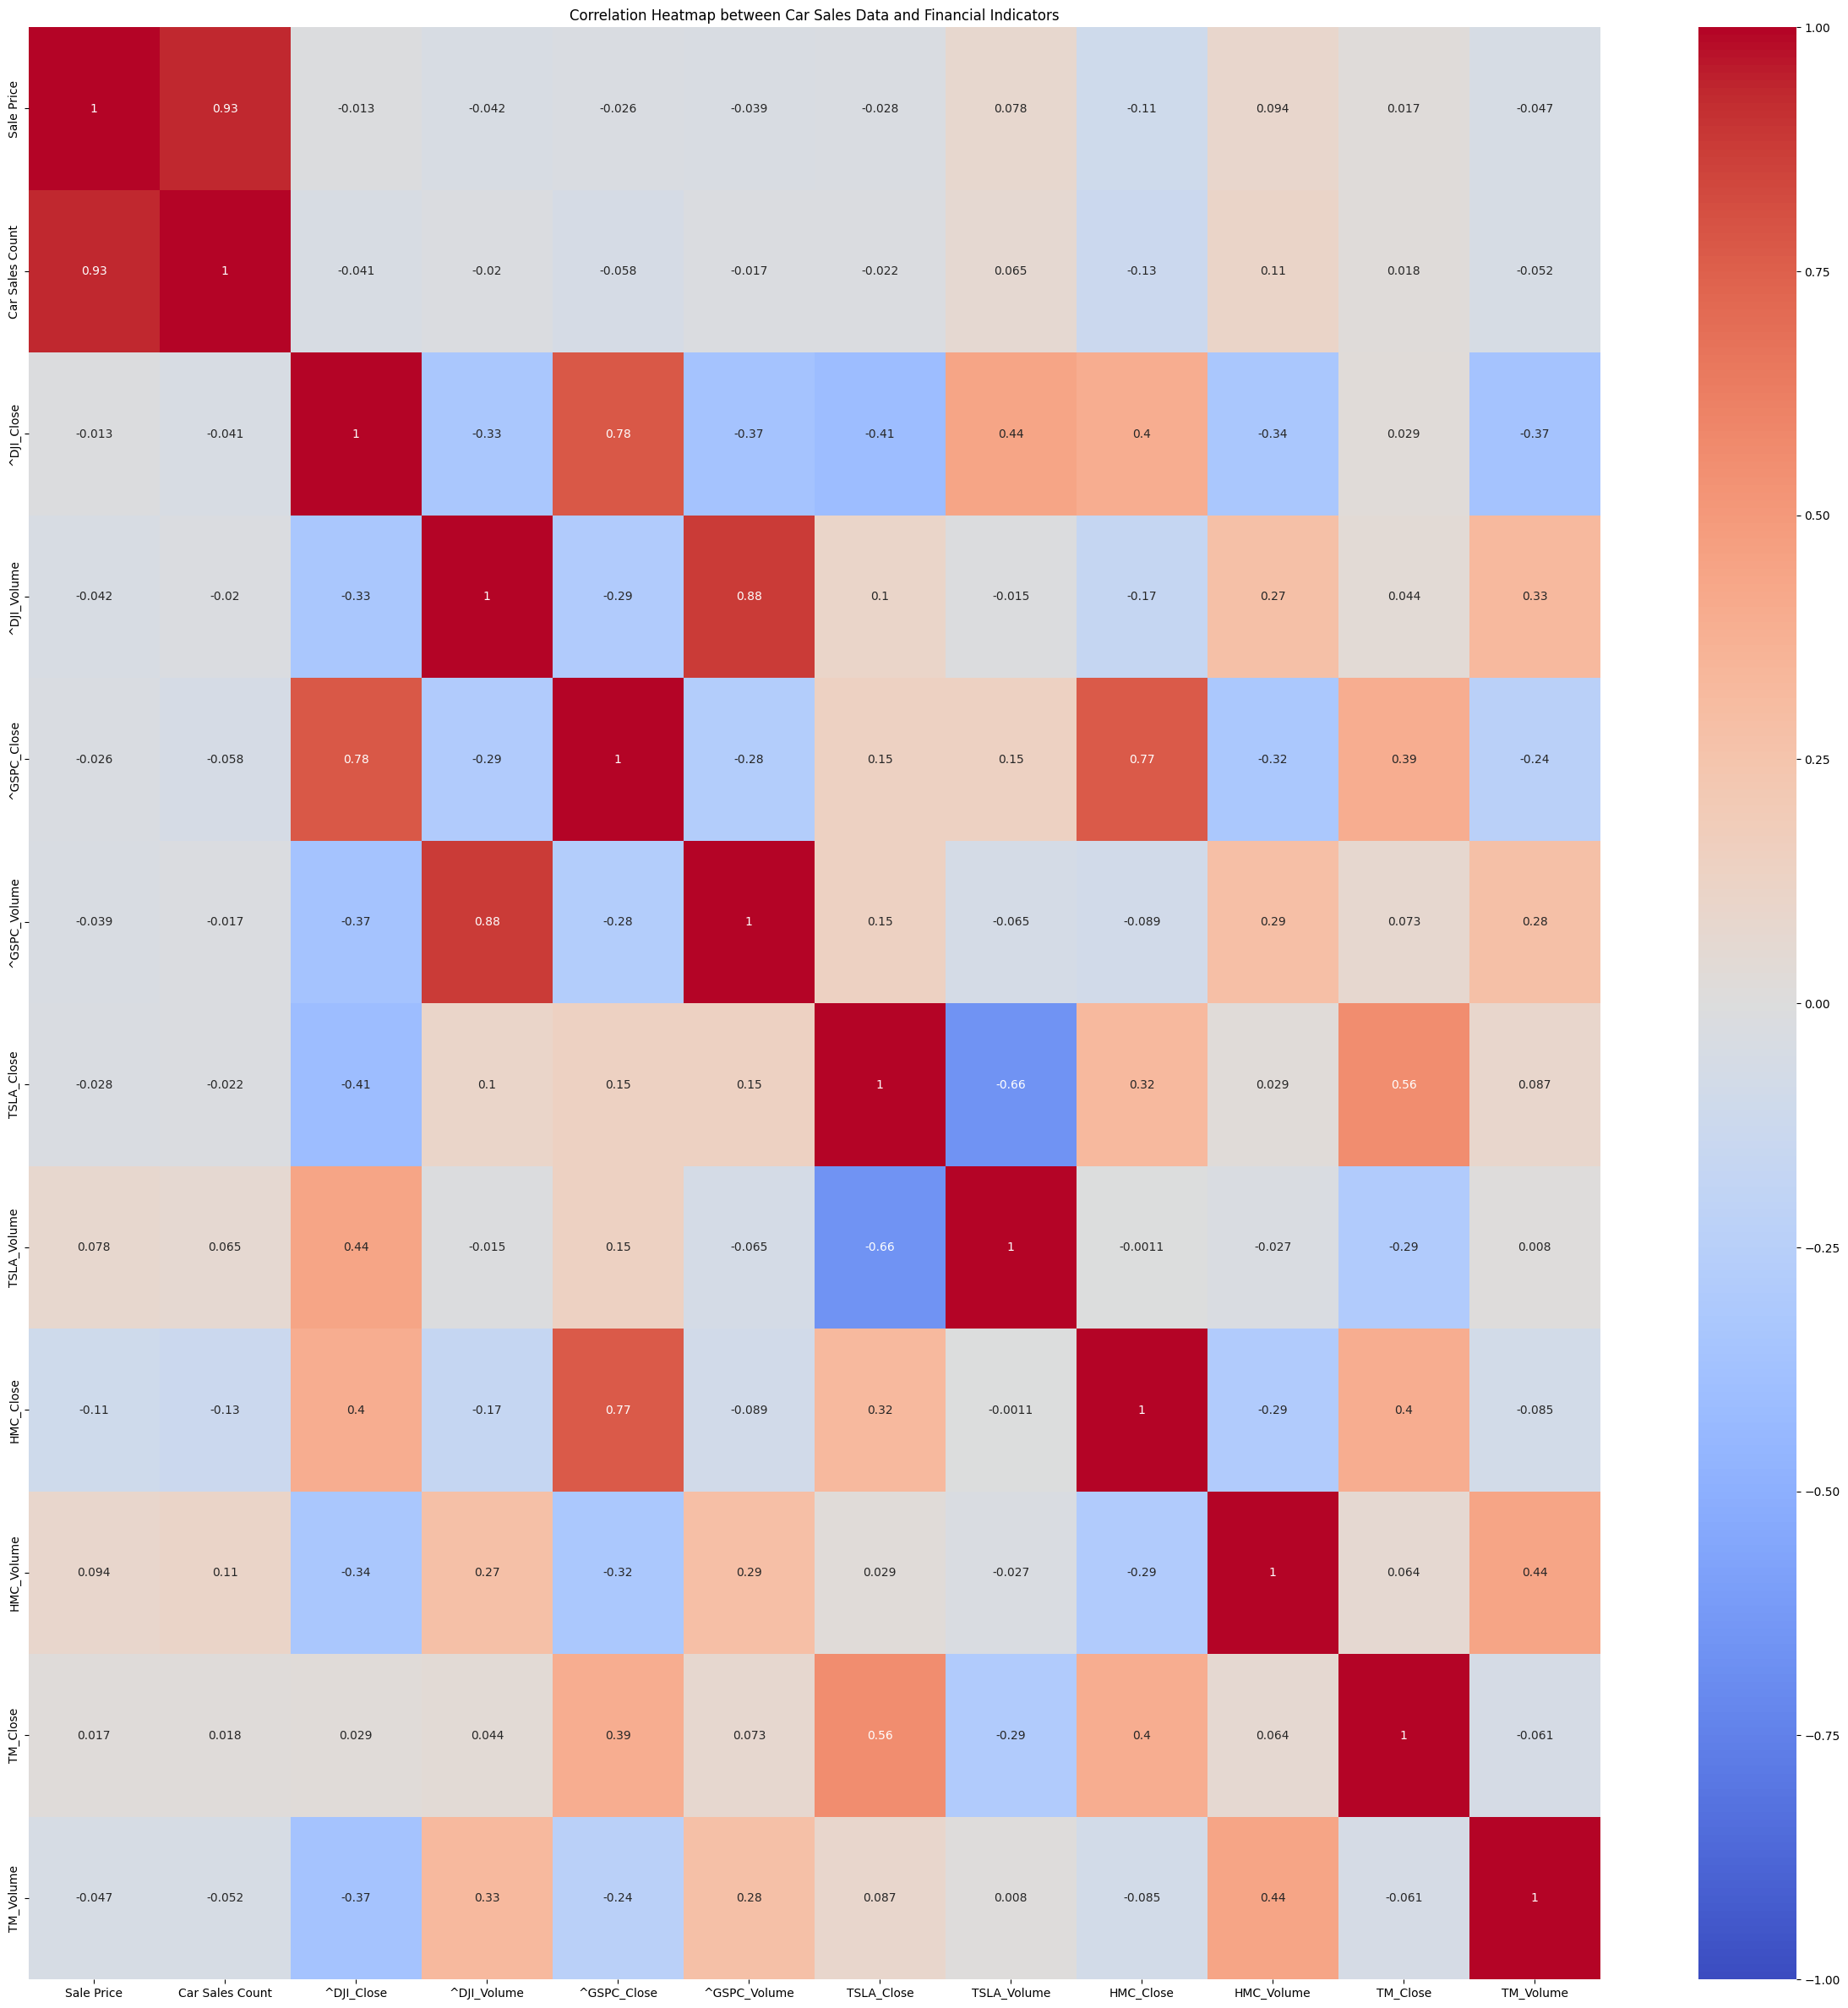

In [12]:
test_columns = ['Sale Price', 'Car Sales Count', '^DJI_Close', 
                '^DJI_Volume', '^GSPC_Close', '^GSPC_Volume', 
                'TSLA_Close', 'TSLA_Volume', 'HMC_Close', 
                'HMC_Volume', 'TM_Close', 'TM_Volume']
corr_matrix = merged_df[test_columns].corr()

plt.figure(figsize=(30, 30))  # Optional: Adjust the figure size
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap between Car Sales Data and Financial Indicators")
plt.show()

## Granger Causality Test

After observing the initial correlation matrix, it was clear that a mere linear snapshot of relationships wouldn't suffice in unveiling the intricacies between car sales data and the financial indicators. This realization led us to deploy the Granger Causality Test. But, what is the rationale behind this decision?

1. **Exploring Temporal Relationships**: 
   - Unlike standard correlation metrics, Granger Causality is designed to detect whether one time series can predict another. This becomes crucial when dealing with sequential data where relationships might manifest after certain time lags.

2. **Beyond Instantaneous Correlations**: 
   - The Correlation Matrix shows how variables relate at the same point in time. However, in many real-world scenarios, especially in financial markets, the effect of one variable might be realized in another after a delay. The Granger Causality Test helps in capturing these delayed influences.

3. **Identifying Leading Indicators**: 
   - By performing this test, we aimed to understand if any financial indicators were "leading" indicators for car sales. Essentially, we wanted to know if changes in these indicators could be used to predict subsequent changes in car sales after a certain number of days.

4. **Enriching Data Insights**: 
   - While the correlation matrix provides a broad understanding of relationships, the Granger Causality Test delves deeper into causative relationships over time. This dual approach ensures a holistic understanding of our datasets.

5. **Informed Decision Making**: 
   - Knowing that a certain financial indicator can predict car sales after a set period is actionable knowledge. It informs strategies, anticipatory measures, and can be a foundation for more complex predictive models.

In essence, the Granger Causality Test allowed us to unearth temporal relationships that a standard correlation analysis might overlook. Our goal was to identify any latent patterns, where changes in our financial indicators might foretell shifts in car sales, even if these effects were delayed. This test was a step towards that deeper understanding.


In [13]:
def granger_test(car_data_column, max_lag=14, alpha=.05, volume_or_close_data=None, test=1):
    """
    Perform a Granger Causality test on columns in a global merged_df dataframe against the provided car_data_column.    This function checks whether the financial market data can potentially predict the car sales data.

    Parameters:
    - car_data_column (str): The column in merged_df to compare against ('Sale Price' or 'Car Sales Count').
    - max_lag (int, optional): Maximum number of lags to check in the Granger Causality test. Defaults to 14.
    - alpha (float, optional): Significance level for the test. Columns with p-values less than alpha will be considered significant. Defaults to 0.05.
    - volume_or_close_data (str, optional): Type of financial data to include in the results, either 'Volume' or 'Close'. If set to None, all columns will be included. Defaults to None.
    - test (int, optional): Type of test to perform. If 1, then check if market data predicts car sales data. If 2, then check if car sales data predicts market data. Defaults to 1.

    Returns:
    - None. Prints and visualizes the significant results.
    """
    
    # columns to skip (related to car sales)
    skip_columns = ['Sale Price', 'Car Sales Count']

    # Initialize dictionary to store significant results
    significant_results = {}

    # Loop through each column in merged_df to perform Granger Causality Test
    for column in merged_df.columns:
        if column not in skip_columns and (not volume_or_close_data or volume_or_close_data in column):
            print(f"Performing Granger Causality Test between {car_data_column} and {column}")
            
            
            # Test 1 is financial market data predicting car sales data
            if test == 1:
                # Keep only rows with non-NaN values for the current column and car_data_column
                temp_data = merged_df[[car_data_column, column]].dropna()
                
            # Test 2 is car sales data predicting fincancial market data
            if test == 2:
                temp_data = merged_df[[column, car_data_column]].dropna()
            
            # Execute the Granger Causality test
            test_result = grangercausalitytests(temp_data, max_lag, verbose=False)
            
            # Initialize a list for significant lags with NaN for all lags up to max_lag
            significant_lags = [(i, np.nan) for i in range(1, max_lag + 1)]
            
            # Update the list with significant results based on p-value and column type (volume or close)
            for lag, result in test_result.items():
                p_value = result[0]['ssr_ftest'][1]
                if p_value < alpha:
                    significant_lags[lag - 1] = (lag, p_value)  # lag - 1 because list is 0-indexed
            
            # Only store the column if there's at least one significant result
            if any([not np.isnan(lag[1]) for lag in significant_lags]):
                significant_results[column] = significant_lags
                print(f"Significant results for {column}: {significant_lags}")

    # Display summary of significant results
    print("Summary of Significant Results:")
    print(significant_results)

    # Convert results to a format suitable for heatmap visualization
    heatmap_data = {}

    for column, lags in significant_results.items():
        for lag, p_value in lags:
            heatmap_data[(column, lag)] = p_value

    heatmap_df = pd.Series(heatmap_data).unstack()

    # Visualize the significant results using a heatmap
    plt.figure(figsize=(12, 6))
    colors = sns.cubehelix_palette(start=.2, rot=-.3, dark=.25, light=.95, reverse=True, as_cmap=True)
    sns.heatmap(heatmap_df, annot=True, cmap=colors, cbar=True, vmin=0, vmax=alpha)
    plt.title(f"Granger Causality Test {test} P-values {car_data_column}")
    plt.xlabel("Lag in days")
    if volume_or_close_data:
        plt.ylabel(f"Financial Indicator in {volume_or_close_data} Data")
    else:
        plt.ylabel(f"Financial Indicator")
    plt.show()



### Can the financial market data help predict the car sales data?

Performing Granger Causality Test between Car Sales Count and ^DJI_Volume
Significant results for ^DJI_Volume: [(1, nan), (2, nan), (3, nan), (4, nan), (5, nan), (6, 0.03752540247496213), (7, 0.019287219782095247), (8, 0.021930329691448397), (9, 0.03738128152015745), (10, nan), (11, nan), (12, nan), (13, nan), (14, nan)]
Performing Granger Causality Test between Car Sales Count and ^GSPC_Volume
Significant results for ^GSPC_Volume: [(1, nan), (2, nan), (3, nan), (4, nan), (5, nan), (6, 0.04219366223191609), (7, nan), (8, 0.04574889766184074), (9, nan), (10, nan), (11, nan), (12, nan), (13, nan), (14, nan)]
Performing Granger Causality Test between Car Sales Count and CL=F_Volume
Performing Granger Causality Test between Car Sales Count and BTC-USD_Volume
Performing Granger Causality Test between Car Sales Count and TSLA_Volume
Significant results for TSLA_Volume: [(1, nan), (2, nan), (3, nan), (4, nan), (5, nan), (6, nan), (7, nan), (8, nan), (9, nan), (10, 0.04409655068635292), (11, n

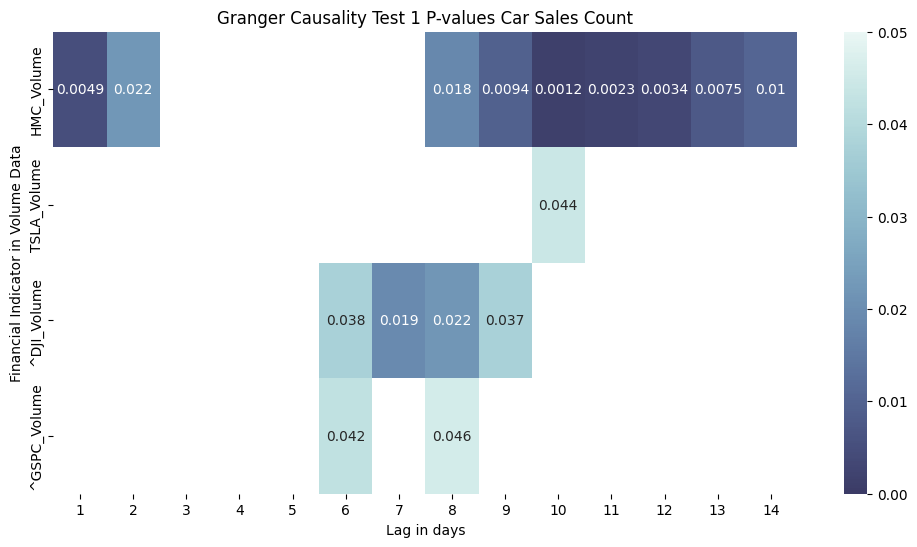

In [14]:
granger_test(car_data_column='Car Sales Count', volume_or_close_data='Volume', test=1)


Performing Granger Causality Test between Sale Price and ^DJI_Close
Performing Granger Causality Test between Sale Price and ^GSPC_Close
Performing Granger Causality Test between Sale Price and CL=F_Close
Performing Granger Causality Test between Sale Price and BTC-USD_Close
Performing Granger Causality Test between Sale Price and TSLA_Close
Performing Granger Causality Test between Sale Price and F_Close
Performing Granger Causality Test between Sale Price and HMC_Close
Significant results for HMC_Close: [(1, 0.0198221850054631), (2, nan), (3, nan), (4, 0.023017282799860546), (5, 0.033549963930094774), (6, nan), (7, nan), (8, nan), (9, nan), (10, nan), (11, nan), (12, nan), (13, nan), (14, nan)]
Performing Granger Causality Test between Sale Price and NSANY_Close
Performing Granger Causality Test between Sale Price and TM_Close
Performing Granger Causality Test between Sale Price and GM_Close
Summary of Significant Results:
{'HMC_Close': [(1, 0.0198221850054631), (2, nan), (3, nan), (

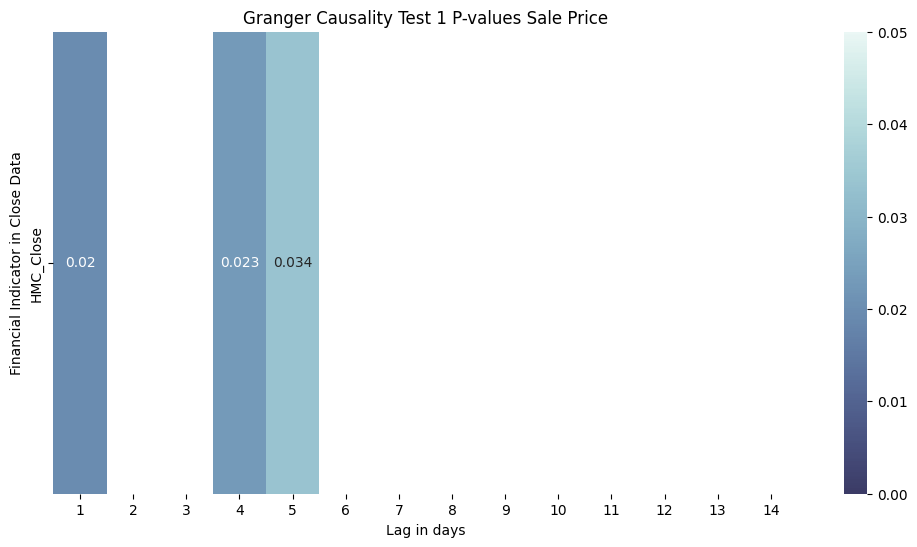

In [15]:
granger_test(car_data_column='Sale Price', volume_or_close_data='Close', test=1)


### Can the car sales data help predict the financial market data?

Performing Granger Causality Test between Car Sales Count and ^DJI_Volume
Performing Granger Causality Test between Car Sales Count and ^GSPC_Volume
Performing Granger Causality Test between Car Sales Count and CL=F_Volume
Performing Granger Causality Test between Car Sales Count and BTC-USD_Volume
Performing Granger Causality Test between Car Sales Count and TSLA_Volume
Significant results for TSLA_Volume: [(1, nan), (2, 0.03829509826254206), (3, nan), (4, nan), (5, nan), (6, nan), (7, nan), (8, nan), (9, nan), (10, nan), (11, nan), (12, nan), (13, nan), (14, nan)]
Performing Granger Causality Test between Car Sales Count and F_Volume
Performing Granger Causality Test between Car Sales Count and HMC_Volume
Performing Granger Causality Test between Car Sales Count and NSANY_Volume
Performing Granger Causality Test between Car Sales Count and TM_Volume
Performing Granger Causality Test between Car Sales Count and GM_Volume
Summary of Significant Results:
{'TSLA_Volume': [(1, nan), (2, 0

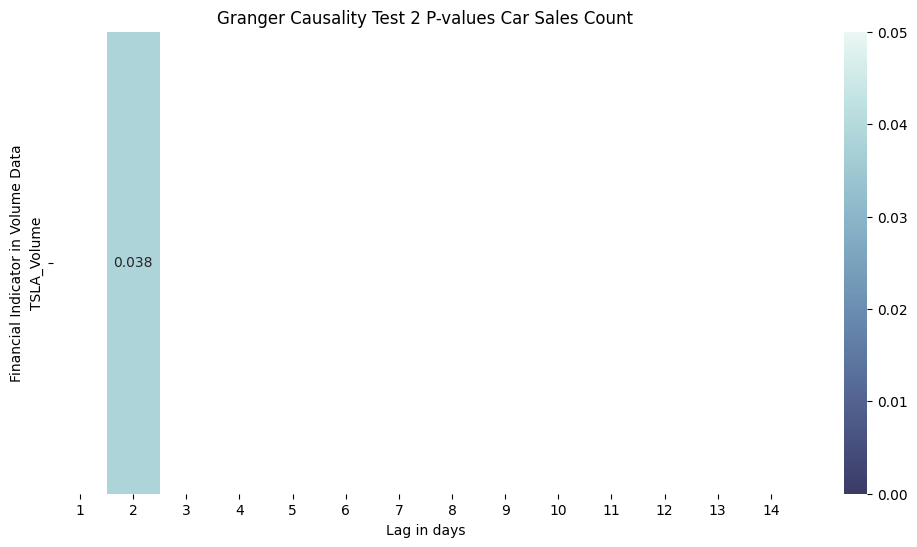

In [16]:
granger_test(car_data_column='Car Sales Count', volume_or_close_data='Volume', test=2)


Performing Granger Causality Test between Sale Price and ^DJI_Close
Performing Granger Causality Test between Sale Price and ^GSPC_Close
Performing Granger Causality Test between Sale Price and CL=F_Close
Performing Granger Causality Test between Sale Price and BTC-USD_Close
Performing Granger Causality Test between Sale Price and TSLA_Close
Performing Granger Causality Test between Sale Price and F_Close
Performing Granger Causality Test between Sale Price and HMC_Close
Performing Granger Causality Test between Sale Price and NSANY_Close
Performing Granger Causality Test between Sale Price and TM_Close
Significant results for TM_Close: [(1, 0.04094177895129504), (2, nan), (3, nan), (4, nan), (5, nan), (6, nan), (7, nan), (8, nan), (9, nan), (10, nan), (11, nan), (12, nan), (13, nan), (14, nan)]
Performing Granger Causality Test between Sale Price and GM_Close
Summary of Significant Results:
{'TM_Close': [(1, 0.04094177895129504), (2, nan), (3, nan), (4, nan), (5, nan), (6, nan), (7, n

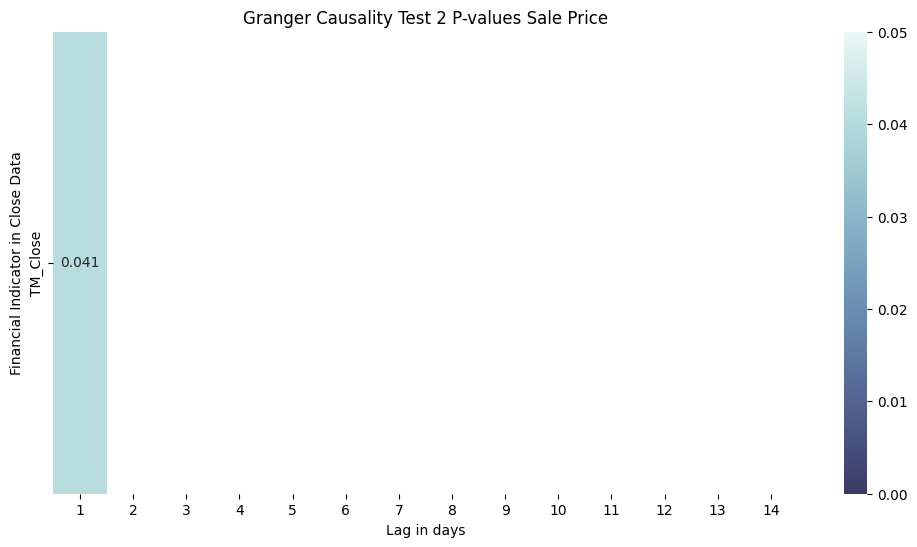

In [17]:
granger_test(car_data_column='Sale Price', volume_or_close_data='Close', test=2)

## Summary of Granger Causality Test Findings

### Objective

The Granger Causality Test was conducted to explore the potential predictive relationships between various financial indicators and car sales metrics, specifically "Car Sales Count" and "Sale Price". The motivation behind this was to determine if there's a significant causative relationship indicating that these financial indicators could be used to forecast car sales in the future. We did a second test to check if the car sales data could be used to predict the financial market data.

### Methodology

We split each analysis into two parts:

1. **Car Sales Count vs. Volume of Financial Indicators**: Here, we aimed to compare the volume data from financial indicators with the count of car sales. This comparison was chosen as both metrics represent a form of quantity.
   
2. **Sale Price vs. Close Price of Financial Indicators**: To maintain consistency in metrics, the total car sales (represented as "Sale Price") was compared with the closing price of financial indicators. Both of these represent a value metric, ensuring a more homogenous comparison.

In both analyses, the Granger Causality Test was executed with lags up to 14 days. A p-value threshold of 0.05 was considered for statistical significance.

### Key Findings for Test 1 (Can the financial market data help predict the car sales data?)

#### For Car Sales Count vs. Volume of Financial Indicators:

1. **Dow Jones Industrial Average Volume (`^DJI_Volume`)**
   - Significant Granger causality observed at lags 6, 7, 8, and 9 (days).
   
2. **S&P 500 Volume (`^GSPC_Volume`)**
   - Significant Granger causality observed at lags 6 and 8.
  
3. **Tesla Volume (`TSLA_Volume`)**
   - Significant Granger causality observed at lag 10.

4. **Honda Volume (`HMC_Volume`)**
   - Significant Granger causality observed at multiple lags: 1, 2, 8, 9, 10, 11, 12, 13, and 14.

#### For Sale Price vs. Close Price of Financial Indicators:

1. **Honda Closing Price (`HMC_Close`)**
   - Significant Granger causality observed at lags 1, 4, and 5.

### Key Findings for Test 2 (Can the car sales data help predict the financial market data?)

#### For Volume of Financial Indicators vs. Sales Count:

1. **Tesla Volume (`TSLA_Volume`)**
   - Significant Granger causality observed at lag 2.

#### For Close Price of Financial Indicators vs. Sales Price:

1. **Toyota Closing Price (`TM_Close`)**
   - Significant Granger causality observed at lag 1.

### Interpretation

These results suggest the presence of predictive information within certain financial indicators that can be valuable for forecasting different aspects of car sales. The distinct time lags identified can be pivotal for building predictive models or for deeper economic analyses.

By distinguishing between quantity (volume/count) and value (price) metrics, the analysis offers a more structured perspective on potential influencing factors in the realm of car sales.


### Volatile Plot Check

This plot shows how total car sales and Honda stock price have evolved throughout a year. To make the plot smoother, a rolling average of 1 week has been applied. Given that the Granger causality showed significant lag between Honda and car sales, we have conducted visual exploration to see if we could find meaningful insights.

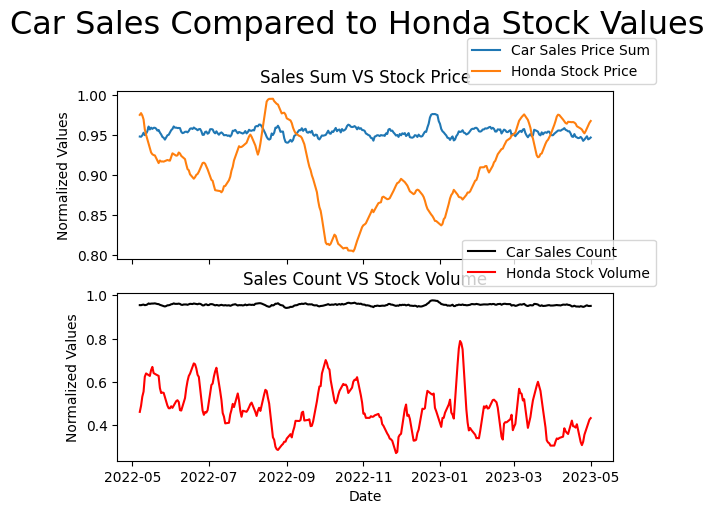

In [18]:
# Just a visual exploration comparing the total price of sold cars
# with an indicator that has lagged correlation with
# No significant findings
# rolling value is used to stablized the time series plot, 7 was used to represent a week
rolling_value = 7
# Normalization of price/ sales sum
normalized_carsales = merged_df["Sale Price"]/merged_df["Sale Price"].max()
normalized_HMCclose = merged_df["HMC_Close"]/merged_df["HMC_Close"].max()
# Normalization of counts/ volume
normalized_carcount = merged_df["Car Sales Count"]/merged_df["Car Sales Count"].max()
normalized_HMCvolume = merged_df["HMC_Volume"]/merged_df["HMC_Volume"].max()

# Plot Normalization
fig, axs = plt.subplots(2)
plt.rcParams["figure.figsize"] = (10,5)
fig.suptitle("Car Sales Compared to Honda Stock Values", size=23, y=1.05)

# Assemble the top graph
#plt.plot(merged_df.index, normalized_carsales) #Normalized
axs[0].plot(merged_df.index, normalized_carsales.rolling(rolling_value).mean(), label="Car Sales Price Sum") #rolling average for a week
#plt.plot(merged_df.index, normalized_HMCclose) #Normalized
axs[0].plot(merged_df.index, normalized_HMCclose.rolling(rolling_value).mean(), label="Honda Stock Price") #rolling average for a week
axs[0].set_title("Sales Sum VS Stock Price")
axs[0].set(xlabel="Date", ylabel="Normalized Values")
axs[0].label_outer()
axs[0].legend(bbox_to_anchor=(1.1, 1),loc="lower right")#, prop={'size': 14})

# Assemble the bottom graph
axs[1].plot(merged_df.index, normalized_carcount.rolling(rolling_value).mean(), label="Car Sales Count", color='black') #rolling average for a week
#plt.plot(merged_df.index, normalized_HMCclose) #Normalized
axs[1].plot(merged_df.index, normalized_HMCvolume.rolling(rolling_value).mean(), label="Honda Stock Volume", color='red') #rolling average for a week
axs[1].set_title("Sales Count VS Stock Volume")
axs[1].set(xlabel="Date", ylabel="Normalized Values")
axs[1].legend(bbox_to_anchor=(1.1, 1),loc="lower right")#, prop={'size': 14})

# This code will output a jpg that can be used in the project
#plt.savefig('Honda_timeseries.jpg', dpi=100)

plt.show()

## Relationship between sold cars and stock values per car maker


We have observed that there is no significant direct correlation considering all the cars that were sold regardless of the maker. Another interesting insight for the dataset would be understanding if there is a relationship between the car brand and the value of the car maker company in the stock market. We will create several SPLOM (scatterplot matrix)  charts to understand the aforementioned relationship and potentially answer questions like the following ones.

- Does the strength of the market price encourage car buyers to select a specific brand?
- Does the number of sold cars seem to have an effect on the stock market?
- Does the lower price of a brand encourage buyers to choose other brands?


Given that the Granger causality showed significan't lagged causality for several lag values when analysing Honda stock prices and Honda traded Volume, we will pay more attention for the results related to Honda.

In [19]:
# Creating a dataframe with the count of cars sold per brand and the the total money made in sales per car maker

sales_sum_per_make = car_sales_df[["Date", "Car Make", "Sale Price"]].groupby(
    ["Date", "Car Make"]).sum().reset_index()
    
sales_count_per_make = car_sales_df[["Date", "Car Make", "Sale Price"]].groupby(
    ["Date", "Car Make"]).count().reset_index()
sales_count_per_make.rename(columns={"Sale Price":"Sale Count"}, inplace=True)

# Merge sales counts with sales money
car_make_sales = sales_sum_per_make.merge(
    sales_count_per_make, left_on=["Date", "Car Make"], right_on=["Date", "Car Make"])
car_make_sales

Date   Car Make  Sale Price  Sale Count
0    2022-05-01  Chevrolet    43590166        1437
1    2022-05-01       Ford    40409923        1356
2    2022-05-01      Honda    40970679        1368
3    2022-05-01     Nissan    40660917        1351
4    2022-05-01     Toyota    41317358        1375
...         ...        ...         ...         ...
1825 2023-05-01  Chevrolet    41981699        1400
1826 2023-05-01       Ford    39909343        1334
1827 2023-05-01      Honda    41052445        1370
1828 2023-05-01     Nissan    41390488        1363
1829 2023-05-01     Toyota    41352495        1372

[1830 rows x 4 columns]

A visual exploration of the same graphs with car sales count and car sales money shows that no additional information is gained with the sales count so the SPLOMs are only created with the sales money for each car maker .Regarding the market values, the same conclusion was reached with stock price and traded volume so only the traded volume is used for the SPLOMs.

In [20]:
# Merging car sales in USD data with market values data

car_make_sales_USD = car_make_sales.pivot_table(values='Sale Price', index='Date', columns='Car Make').reset_index()
car_make_USD_market= pd.merge(car_make_sales_USD ,df, on='Date', how="left").ffill().bfill()

car_makes = list(car_make_sales["Car Make"].unique())
car_make_tickers = {"Ford": "F","Honda": "HMC","Nissan": "NSANY","Toyota": "TM", "Chevrolet": "GM"}

# Rename the car maker column
make_sales_column_names = [make + "_sales_USD" for make in car_makes]
make_sales_column_names_dict = dict(zip(car_makes,make_sales_column_names))
car_make_USD_market.rename(columns = make_sales_column_names_dict, inplace=True)

# making a list of columns to use for the relationship between car make sales and closing stock value
close_SPLOM_columns = []
for item in car_make_tickers.items():
    close_SPLOM_columns.append(item[0] + "_sales_USD")
    close_SPLOM_columns.append(item[1]+"_Close")

# making a list of columns to use for the relationship between car make sales and traded volume
volume_SPLOM_columns = []
for item in car_make_tickers.items():
    volume_SPLOM_columns.append(item[0] + "_sales_USD")
    volume_SPLOM_columns.append(item[1]+"_Volume")




In [21]:
display(car_make_USD_market.head())

Date  Chevrolet_sales_USD  Ford_sales_USD  Honda_sales_USD  \
0 2022-05-01           43590166.0      40409923.0       40970679.0   
1 2022-05-02           42008077.0      41169903.0       40000517.0   
2 2022-05-03           39948356.0      41642280.0       40654296.0   
3 2022-05-04           41633963.0      39990470.0       41688608.0   
4 2022-05-05           40677506.0      39188724.0       42612292.0   

   Nissan_sales_USD  Toyota_sales_USD    ^DJI_Close  ^DJI_Volume  ^GSPC_Close  \
0        40660917.0        41317358.0  33061.500000  453390000.0  4155.379883   
1        38769060.0        41242184.0  33061.500000  453390000.0  4155.379883   
2        41782920.0        39177428.0  33128.789062  364420000.0  4175.479980   
3        44373157.0        40809479.0  34061.058594  411060000.0  4300.169922   
4        40550948.0        39608564.0  32997.968750  448420000.0  4146.870117   

   ^GSPC_Volume  ...  F_Close    F_Volume  HMC_Close  HMC_Volume  NSANY_Close  \
0  5.163790e+09  ...    14.27  64734000.0  26.260000   1008700.0         7.90   
1  5.163790e+09  ...    14.27  64734000.0  26.260000   1008700.0         7.90   
2  4.582050e+09  ...    14.56  55734200.0  26.580000   1000500.0         7.99   
3  5.136360e+09  ...    14.98  59774900.0  27.120001    774300.0         8.13   
4  5.077030e+09  ...    14.53  57889200.0  26.350000   1116000.0         7.88   

   NSANY_Volume    TM_Close  TM_Volume   GM_Close   GM_Volume  
0      122400.0  170.690002   178500.0  38.450001  16119900.0  
1      122400.0  170.690002   178500.0  38.450001  16119900.0  
2      142200.0  172.059998   163600.0  39.939999  19132700.0  
3       74400.0  174.850006   204700.0  41.169998  15813700.0  
4       74300.0  169.929993   331700.0  39.950001  15317100.0  

[5 rows x 26 columns]

### Daily relation between market prices and cars sold per maker

Text(0.5, 1.04, 'Daily car make sales data vs car make stocks data')

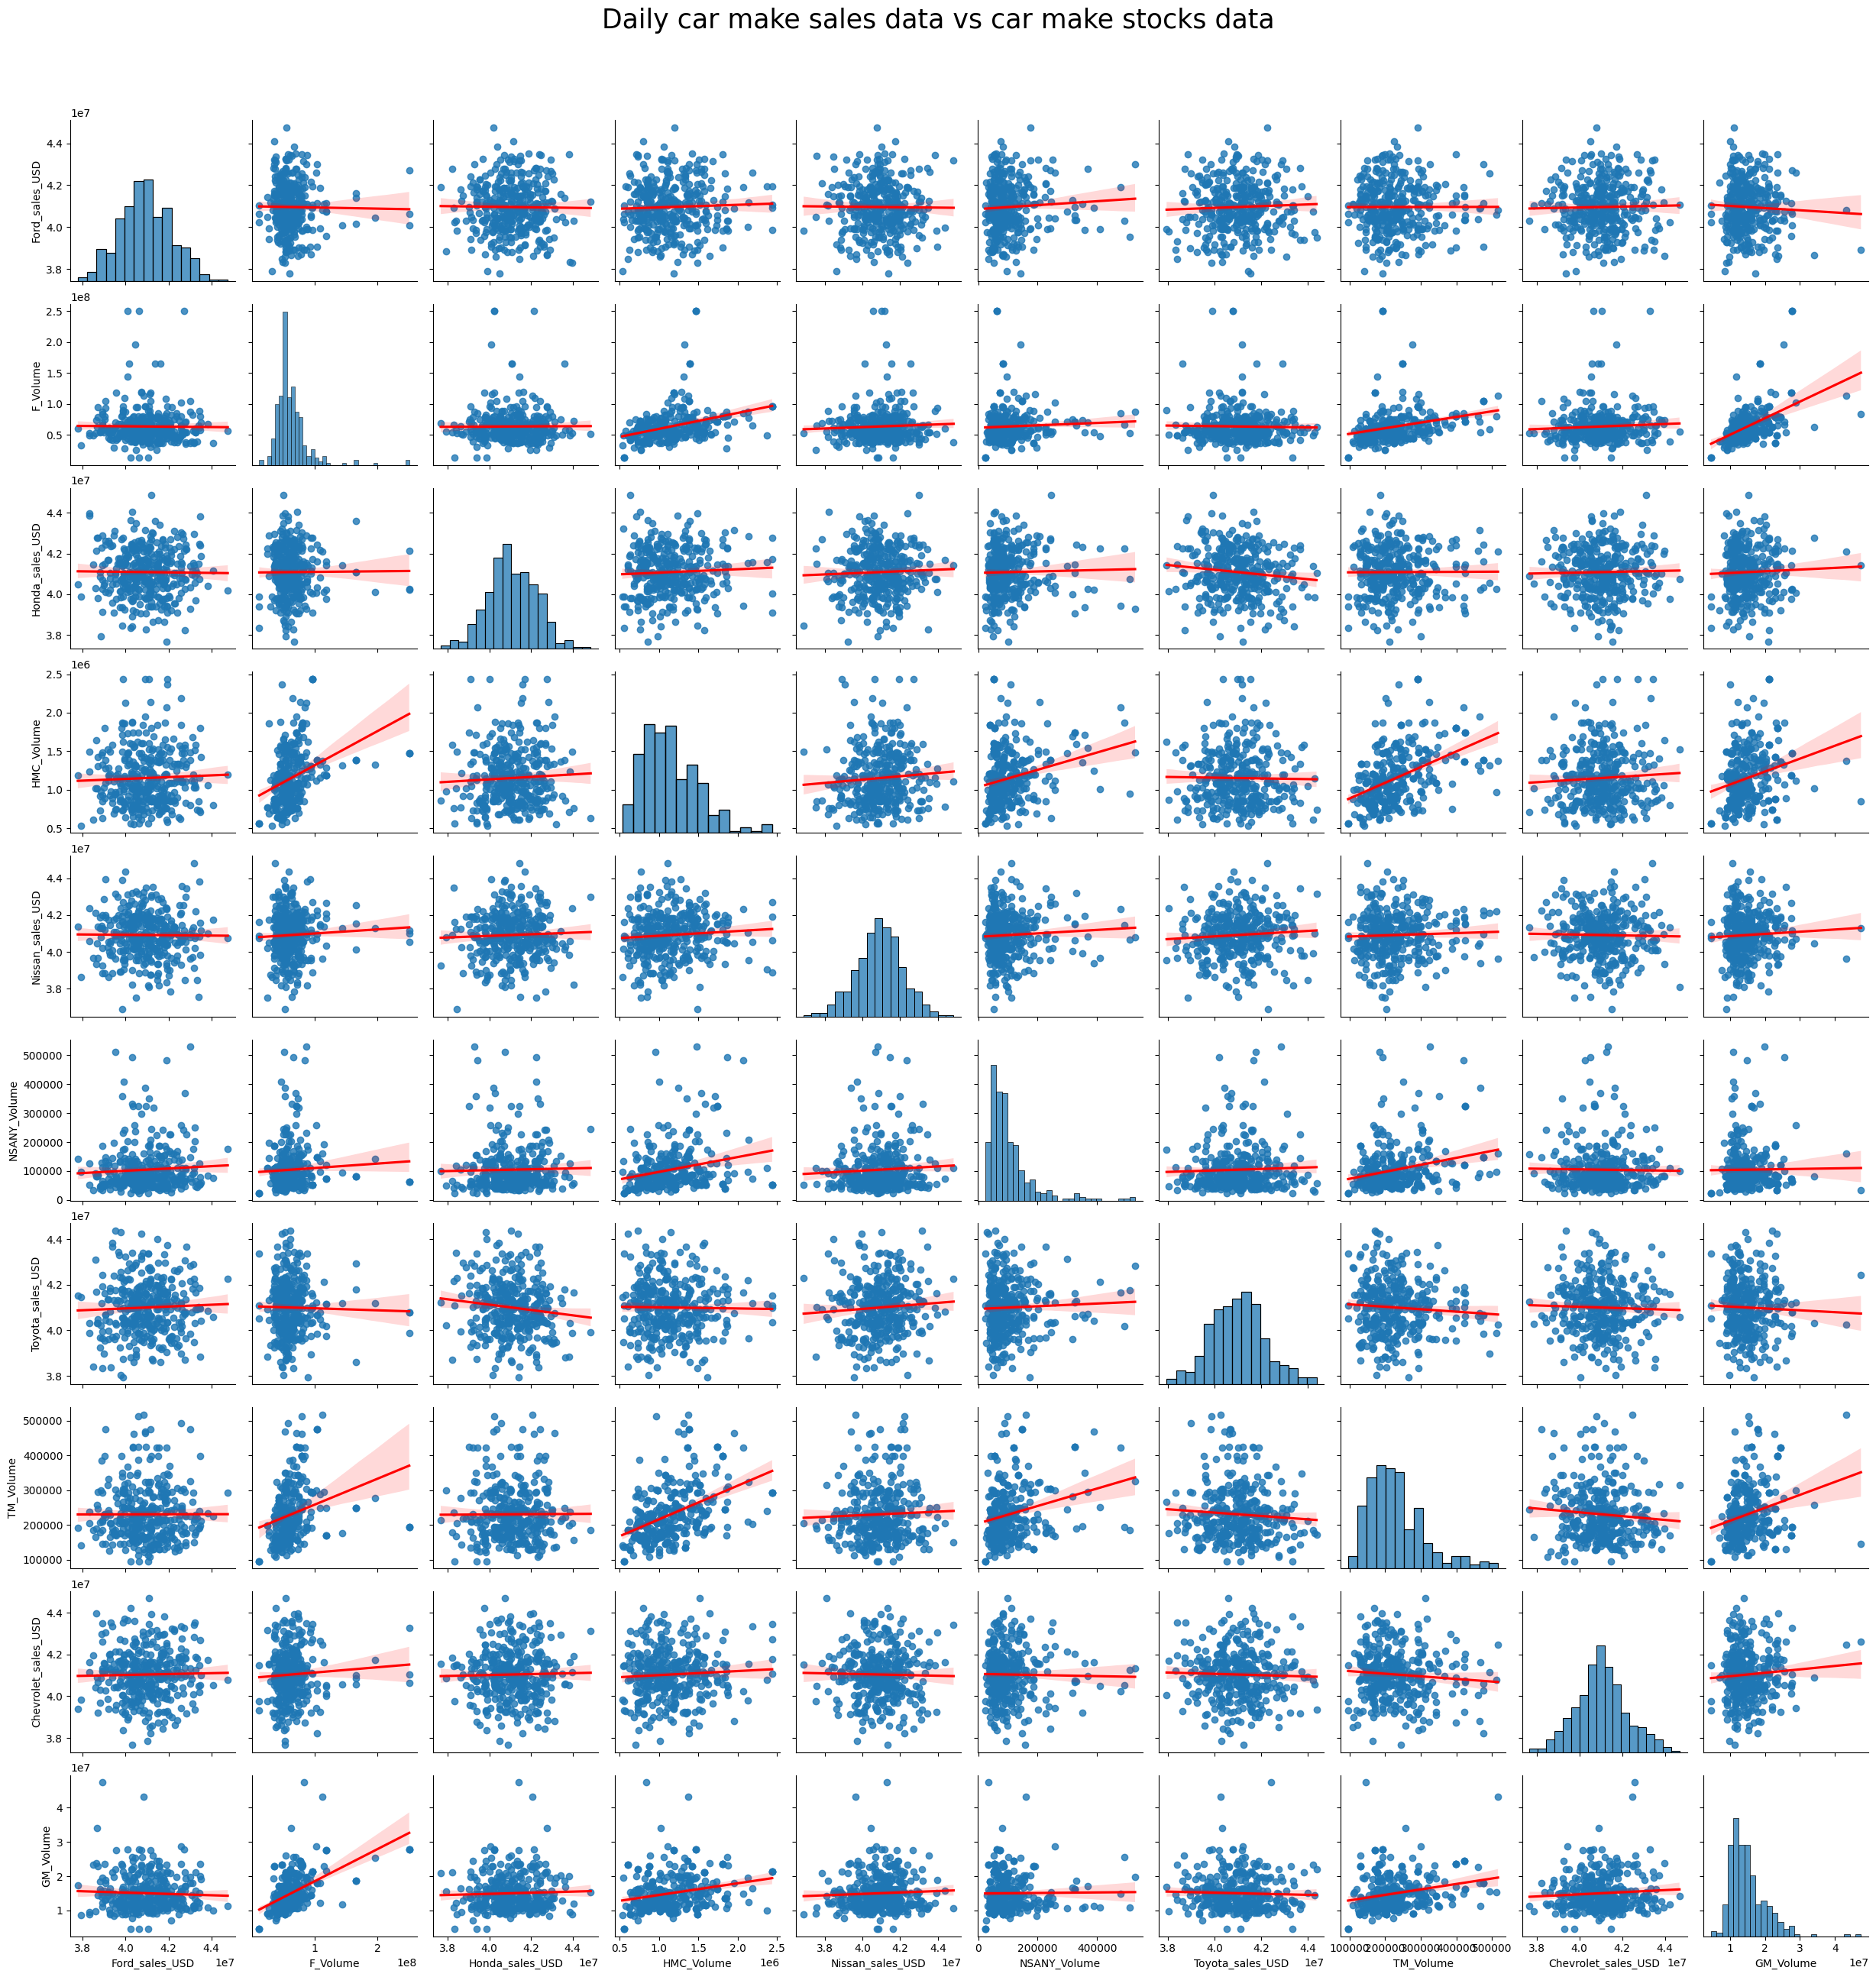

In [22]:
# Creating the SPLOM showing the relation between total sales per day and traded volume of the car makers


splom_day = sns.pairplot(car_make_USD_market[volume_SPLOM_columns],
                        kind='reg',diag_kind='auto', plot_kws={'line_kws':{'color':'red'}})

splom_day.fig.suptitle("Daily car make sales data vs car make stocks data", y=1.04, fontsize=25)


Given that there are too many points in the scatterplots, instead of plotting the days we will also do the same exercise with the weeks of the year and months. For this purpose we will get the sum of USD sales per car make using weekly data and monthly data

In [23]:
# Creating the data to make SPLOMS for monthly information

# Extracting week and month from the dates
car_make_sales_USD["Week of Year"] = car_make_sales_USD["Date"].apply(lambda x: x.isocalendar().week)
car_make_sales_USD["Month of Year"] = car_make_sales_USD["Date"].apply(lambda x: x.month)

# drop Date to apply groupby 
car_make_sales_USD_week = car_make_sales_USD.drop(["Date", "Month of Year"], axis="columns")
car_make_sales_USD_month = car_make_sales_USD.drop(["Date", "Week of Year"], axis="columns")

# Create final df with sales for monthly and weekly SPLOM
weekly_sales_for_SPLOM = car_make_sales_USD_week.groupby("Week of Year").sum().reset_index()
monthly_sales_for_SPLOM = car_make_sales_USD_month.groupby("Month of Year").sum().reset_index()


# extracting week and month from market value dates
SPLOM_market_df = df.copy().reset_index()
SPLOM_market_df["Week of Year"] = SPLOM_market_df["Date"].apply(lambda x: x.isocalendar().week)
SPLOM_market_df["Month of Year"] = SPLOM_market_df["Date"].apply(lambda x: x.month)

# Create final df with market values for monthly and weekly SPLOM
# We will use average market values
weekly_market_for_SPLOM = SPLOM_market_df.drop(["Date", "Month of Year"], axis="columns").groupby(
    "Week of Year").mean().reset_index()
monthly_market_for_SPLOM = SPLOM_market_df.drop(["Date", "Week of Year"], axis="columns").groupby(
    "Month of Year").mean().reset_index()

# merging market df values with sales df values for month and weeks
week_full_df_SPLOM = weekly_sales_for_SPLOM.merge(weekly_market_for_SPLOM,on="Week of Year")
week_full_df_SPLOM.rename(columns = make_sales_column_names_dict, inplace=True)

month_full_df_SPLOM = monthly_sales_for_SPLOM.merge(monthly_market_for_SPLOM,on="Month of Year")
month_full_df_SPLOM.rename(columns = make_sales_column_names_dict, inplace=True)



### Weekly relation between market prices and cars sold per maker

Text(0.5, 1.04, 'Weekly car make sales data vs car make stocks data')

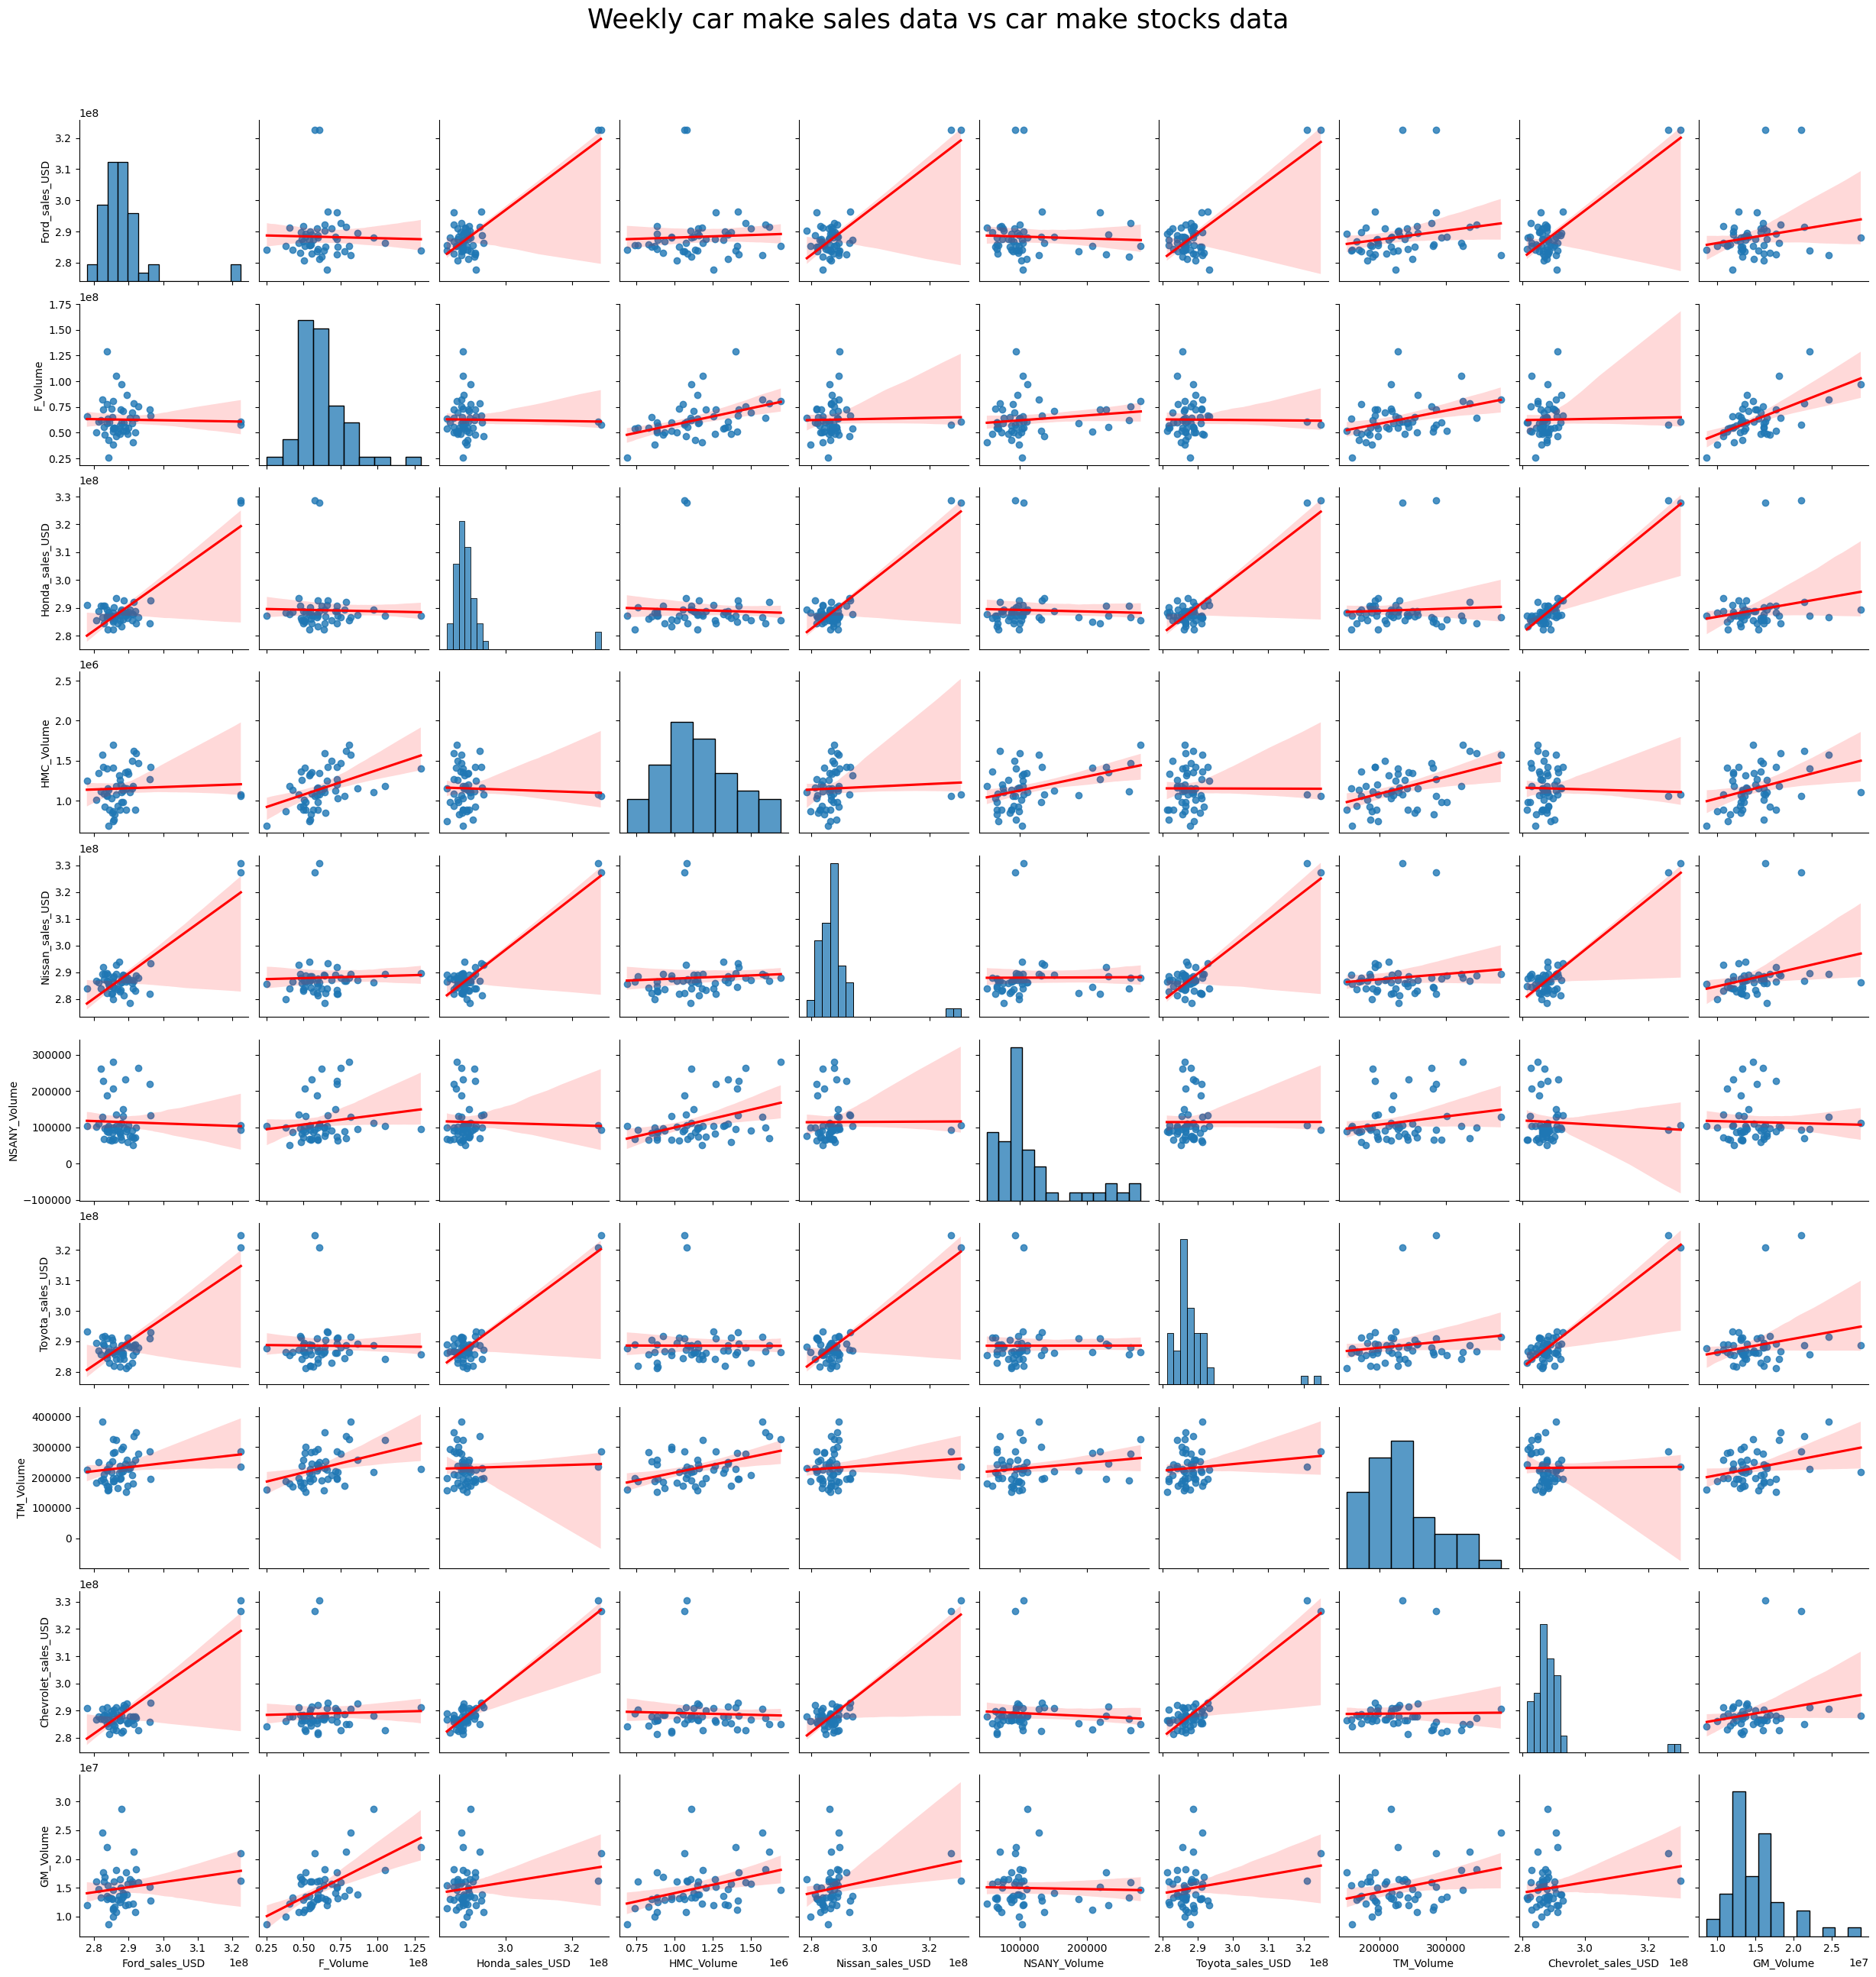

In [24]:
# Creating a SPLOM with weekly values

splom_week = sns.pairplot(week_full_df_SPLOM[volume_SPLOM_columns],
                            kind='reg',diag_kind='auto', plot_kws={'line_kws':{'color':'red'}})
splom_week.fig.suptitle("Weekly car make sales data vs car make stocks data", y=1.04, fontsize=25)


### Weekly relation between market prices and cars sold per maker without outliers

After observing that the graph above has several outliers that distort the results, we have eliminated the outliers for the next chart

Text(0.5, 1.04, 'Weekly car make sales data vs car make stocks data without outliers')

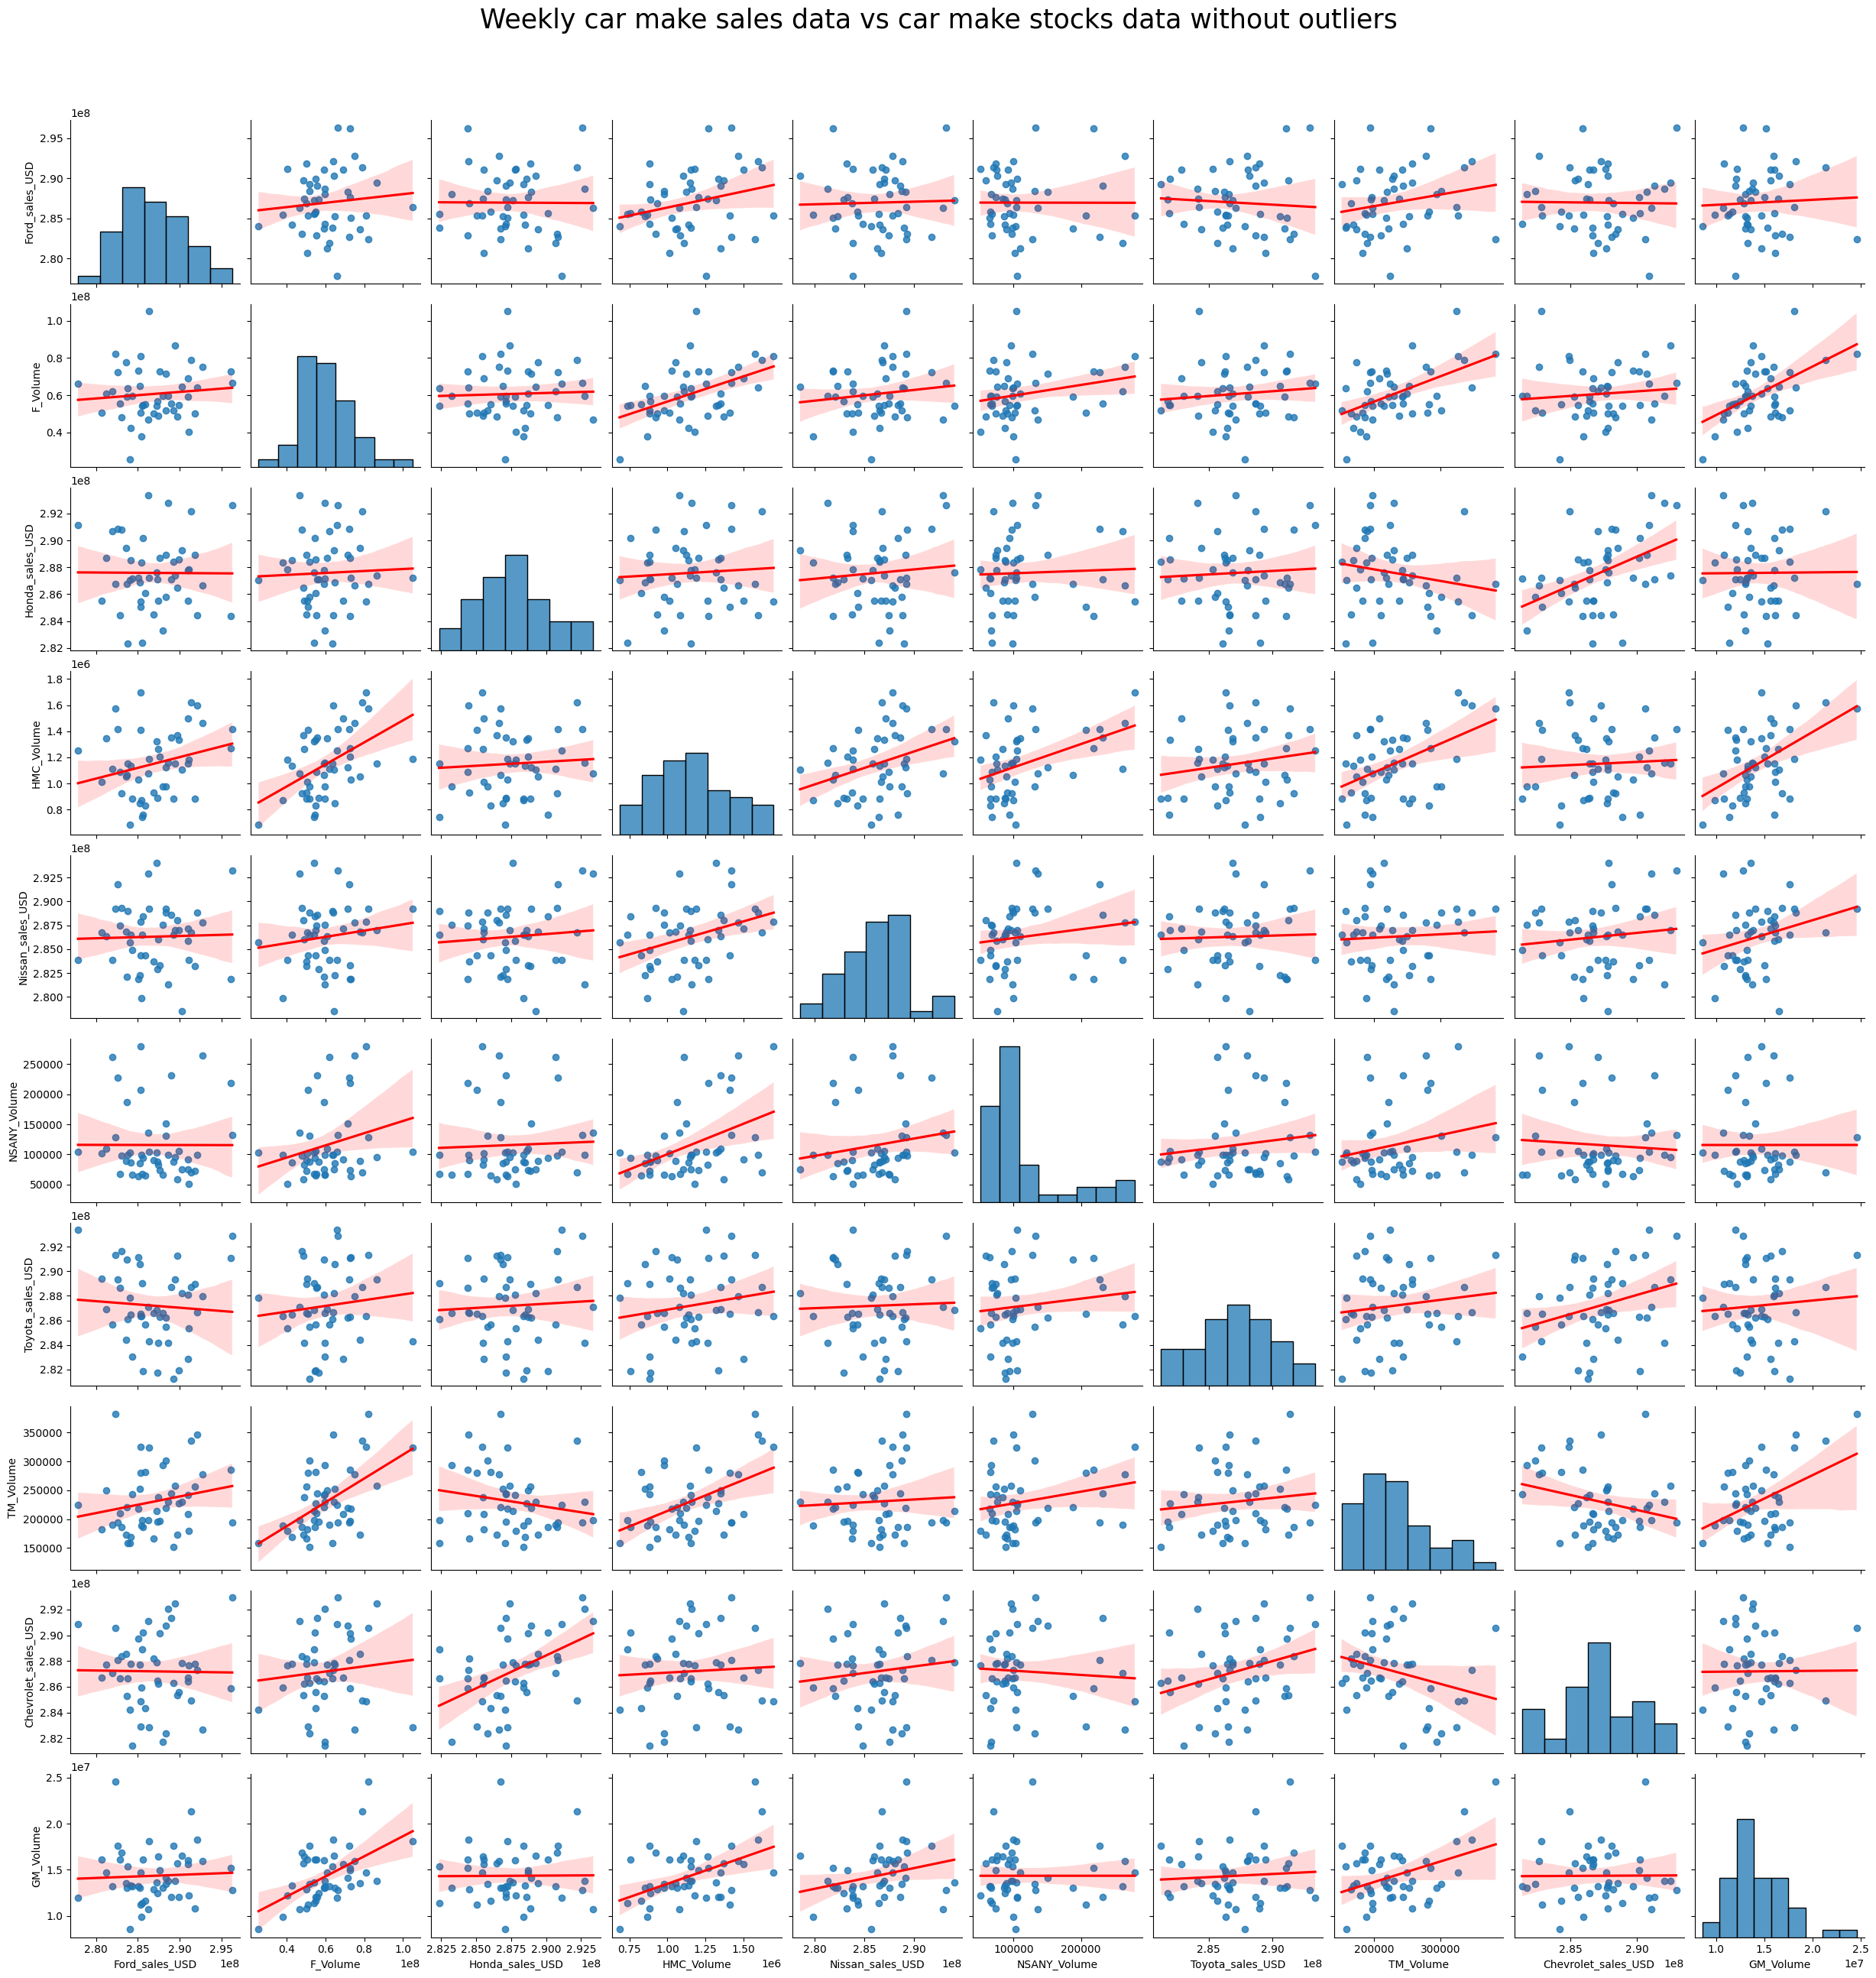

In [25]:
# This cell does the same and the previous one but eliminates outliers before plotting

a = week_full_df_SPLOM[volume_SPLOM_columns]
splom_week2 = sns.pairplot(a[(np.abs(stats.zscore(a)) < 3).all(axis=1)],
                            kind='reg',diag_kind='auto', plot_kws={'line_kws':{'color':'red'}})

splom_week2.fig.suptitle("Weekly car make sales data vs car make stocks data without outliers",
                        y=1.04, fontsize=25)


### Monthly relation between market prices and cars sold per maker

Text(0.5, 1.04, 'Monthly car make sales data vs car make stocks data')

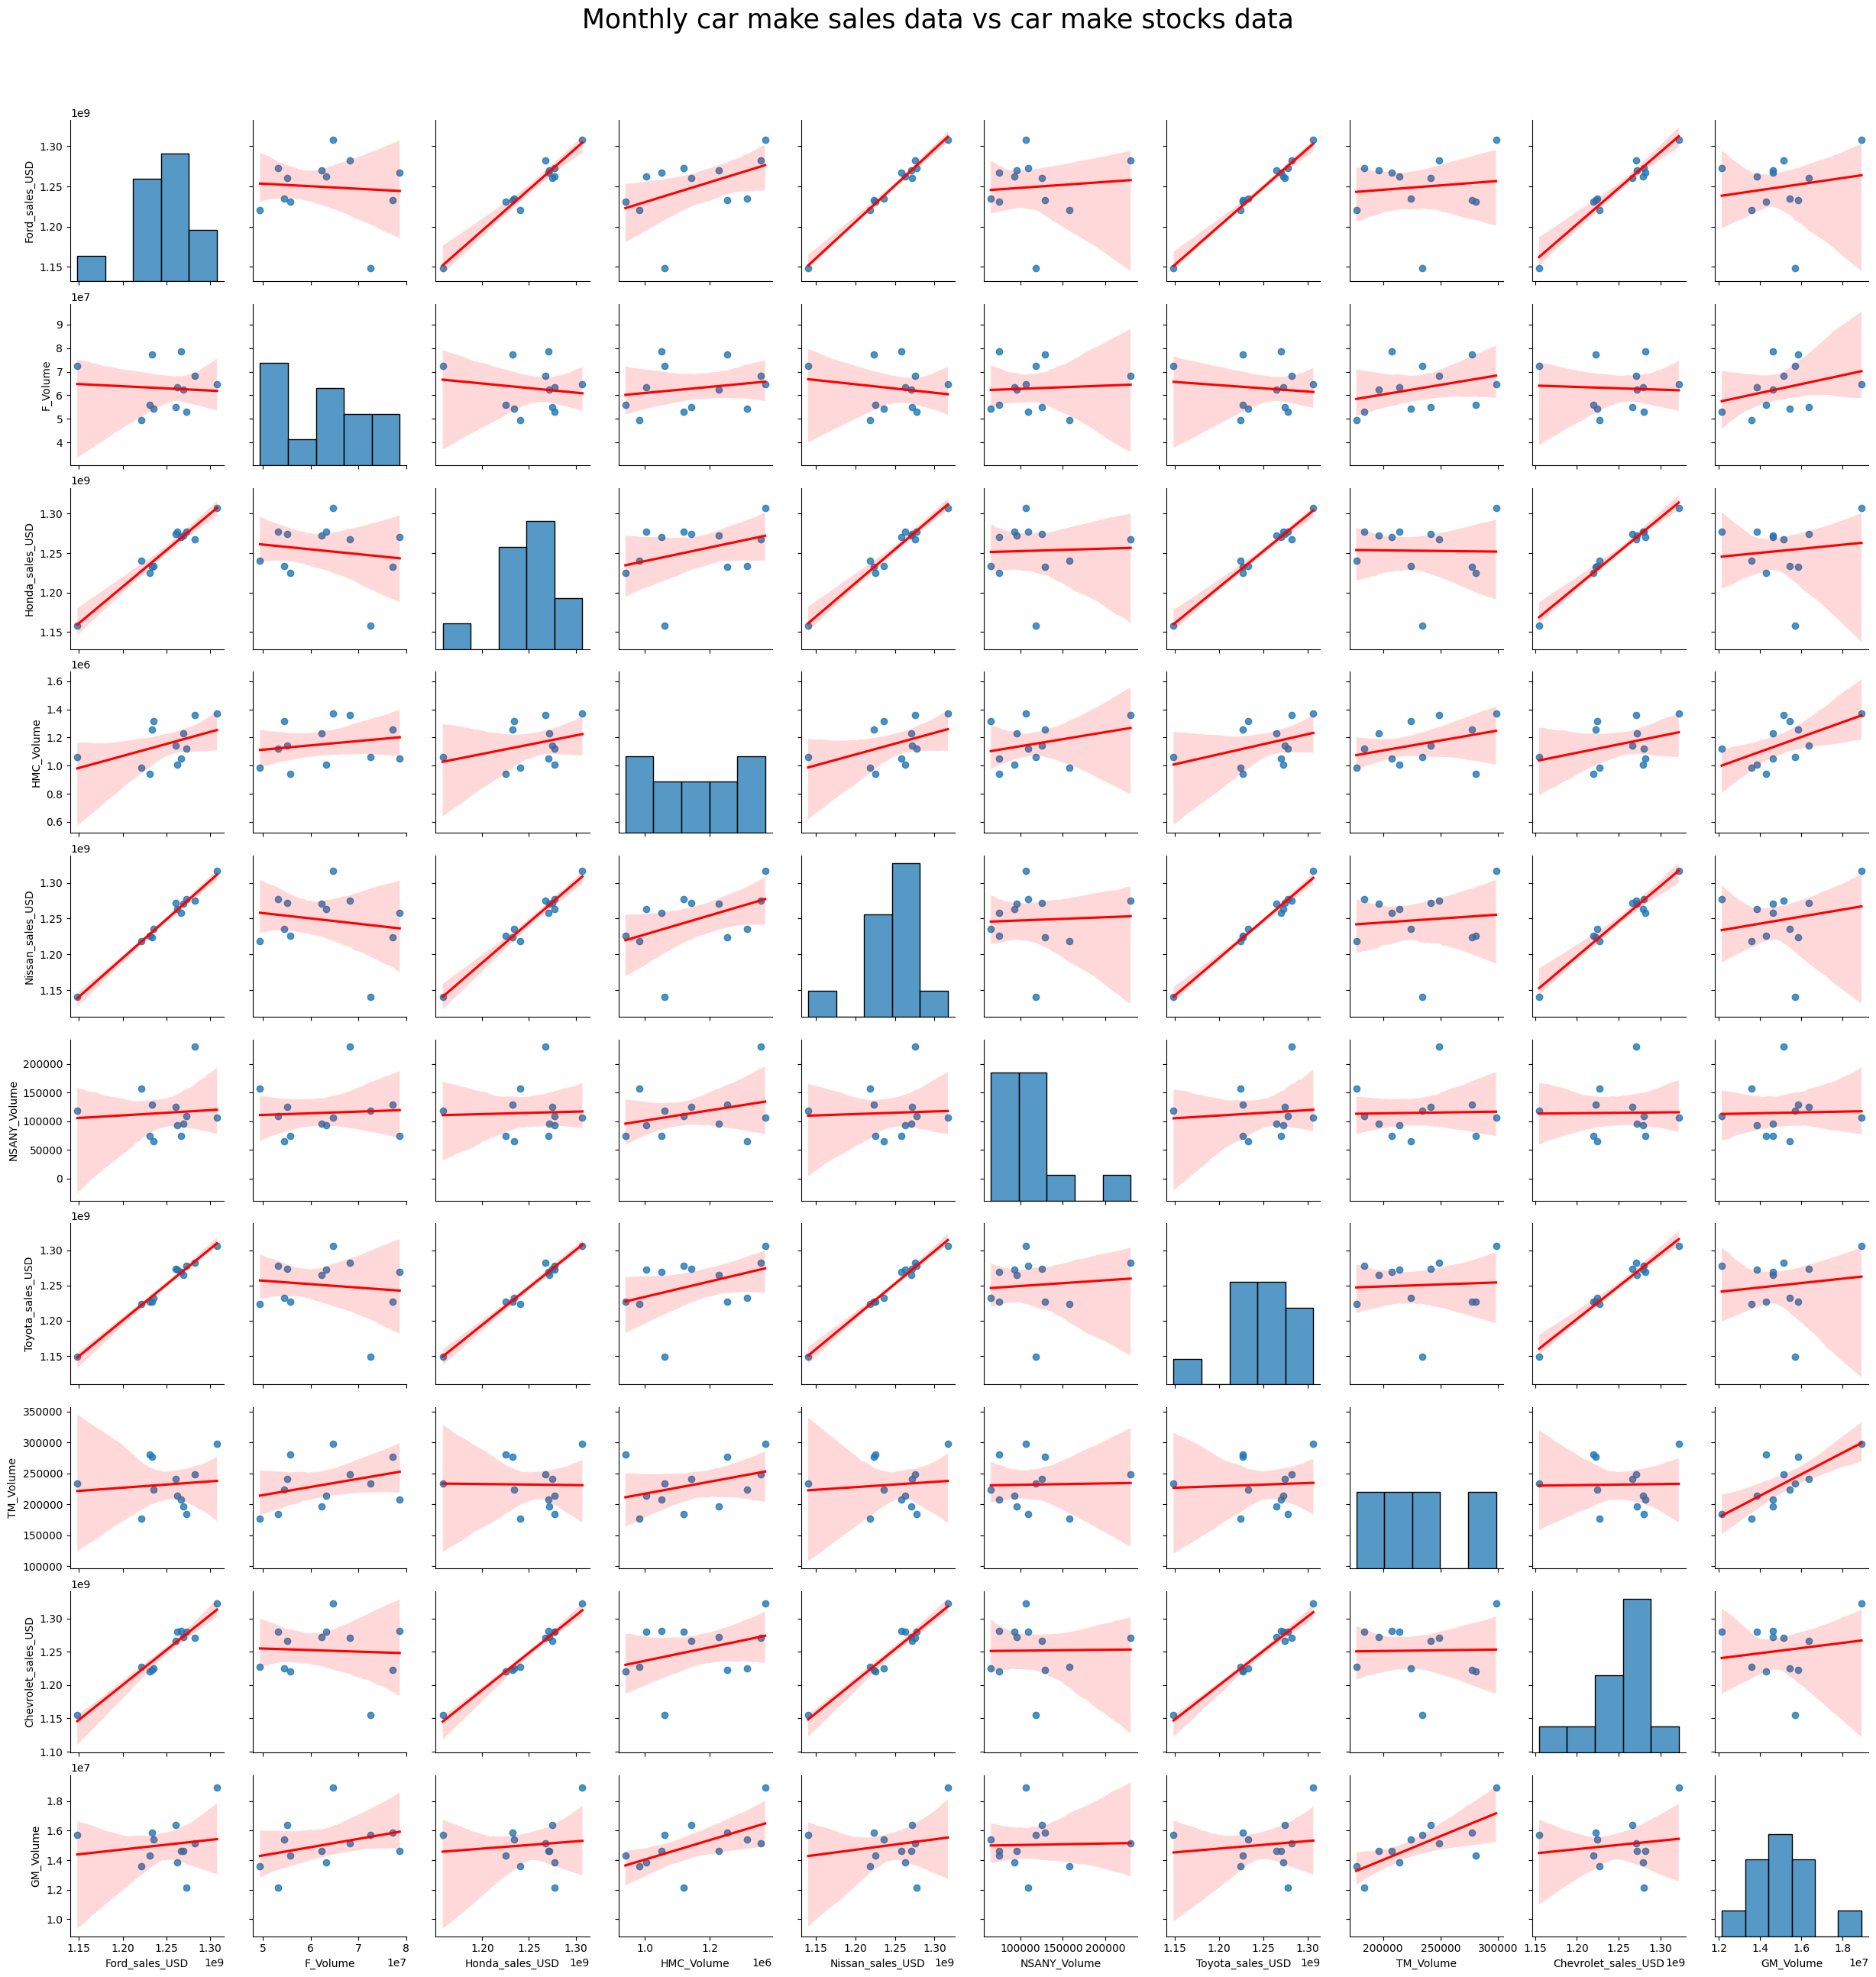

In [26]:
# Creating a SPLOM with monthly values

splom_month = sns.pairplot(month_full_df_SPLOM[volume_SPLOM_columns],
                            kind='reg',diag_kind="auto", plot_kws={'line_kws':{'color':'red'}})

splom_month.fig.suptitle("Monthly car make sales data vs car make stocks data", y=1.04, fontsize=25)


## Analysing Honda

Given that the granger causality text indicates causality between Honda stock and car sales, we have analysed those specific values to understand the relationship between them.

Text(0.5, 1.04, 'Monthly Honda sales data vs Honda stocks data')

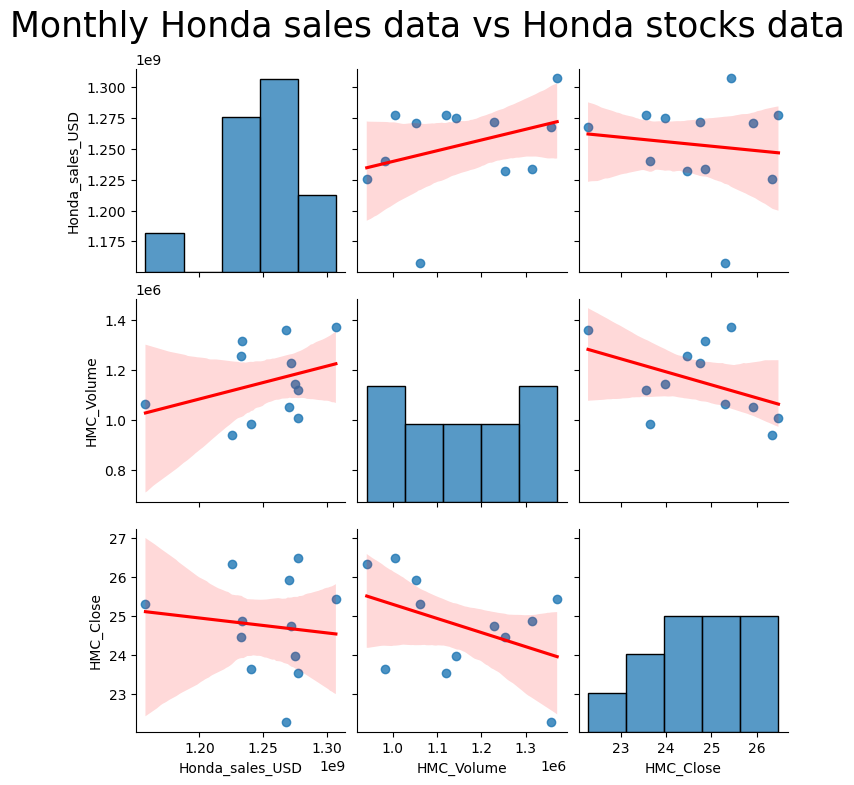

In [27]:
# Creating Honda SPLOM with Total Honda sales in USD

Honda_SPLOM = month_full_df_SPLOM[["Honda_sales_USD", "HMC_Volume", "HMC_Close"]]

splom_month_Honda = sns.pairplot(Honda_SPLOM, kind='reg',diag_kind="auto", plot_kws={'line_kws':{'color':'red'}})

splom_month_Honda.fig.suptitle("Monthly Honda sales data vs Honda stocks data",
                                y=1.04, fontsize=25)

# This code will output a jpg that can be used in the project
#splom_month_Honda.savefig('Honda_SPLOM.jpg', dpi=100)

## Summary of SPLOM Findings on sales per maker

### Objective

We conducted a visual exploration of the data to observe the relationship between sales per car maker and stock market parameters like traded volume and stock closing price.

### Methodology

Create SPLOMs (scatterplot matrix) to relate all the parameters between each other.

### Key Findings

#### Daily values
- There is a very low correlation between car sales and market values (slope near zero).
- There is a very low correlation of car sales between different makers.
- There is a slightly positive correlation in traded volumes which indicates that good trading days are usually positive for all makers.

#### Weekly values
- We can see higher correlation between stock values and and sales per car maker. However, is not a very clear correlation and slope values are low.
- The positive correlation between traded volume mantains among the different stocks.

#### Monthly values
- There is a very strong positive correlation between car sales of different makers. It indicates that months with good sales are positive for all makers. For instance, selling many Ford cars one month does not mean that less Chrevrolets are sold, but it means that more cars are sold in general.
- In general the positive correlation between the traded volume is mantained but the slopes are in general lower.

#### Honda Monthly values
- There is a positive slope when relating traded volume with Honda sales, meaning that the more traded volume in Honda stocks, more cars are sold in a month's time.
- When comparing stock closing value to the cars sold, the slope is slightly negative, meaning that the months with lower closing price have higher sales




# Appendix 

### PIP Freeze 

This shows all the modules installed in the python instance.

In [28]:
pip freeze

absl-py==1.3.0
agate==1.6.3
alembic==1.11.1
altair==4.2.2
anyio==3.6.2
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arrow==1.2.3
asn1crypto==1.5.1
asttokens==2.0.8
astunparse==1.6.3
attrs==22.1.0
Automat==20.2.0
Babel==2.10.3
backcall==0.2.0
bcrypt==4.0.1
beautifulsoup4==4.11.1
bleach==5.0.1
blis==0.7.9
boto3==1.24.95
botocore==1.27.95
branca==0.5.0
cachetools==5.2.0
catalogue==2.0.8
certifi==2022.9.24
cffi==1.15.1
charset-normalizer==2.1.1
click==8.1.3
click-plugins==1.1.1
clickhouse-driver==0.2.4
clickhouse-sqlalchemy==0.2.2
cligj==0.7.2
confection==0.0.3
constantly==15.1.0
contourpy==1.0.5
cryptography==36.0.2
cssselect==1.1.0
cycler==0.11.0
cymem==2.0.7
datascience==0.17.5
debugpy==1.6.3
decorator==5.1.1
defusedxml==0.7.1
dill==0.3.5.1
dnspython==2.2.1
duckdb==0.8.1
duckdb-engine==0.7.0
entrypoints==0.4
executing==1.1.1
fastjsonschema==2.16.2
filelock==3.8.0
Fiona==1.8.22
flatbuffers==22.9.24
folium==0.13.0
fonttools==4.37.4
frozendict==2.3.8
future==0.18.2
gast=

### Import Vehicle Fuel Economy Dataset

The dataset is available in the following website. This data set was a preliminary data set and was not used. We did not need an additional data set. For future work this data source may be desired.

https://www.fueleconomy.gov/feg/ws/#ft9

In [29]:
# raw_fuel_economy_df = pd.read_csv("https://www.fueleconomy.gov/feg/epadata/vehicles.csv", low_memory=False)
# raw_fuel_economy_df.head()
# raw_fuel_economy_df.shape

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=70337ec4-2598-4a20-9e82-38b4f4c44d51' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>